In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "background"
z_diff = 0.1


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

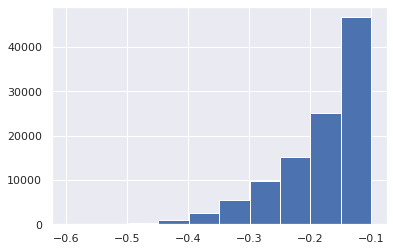

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

106039

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

3it [00:00, 26.37it/s]

9it [00:00, 30.94it/s]

14it [00:00, 34.60it/s]

20it [00:00, 39.50it/s]

26it [00:00, 43.57it/s]

33it [00:00, 48.33it/s]

40it [00:00, 52.42it/s]

46it [00:00, 50.84it/s]

52it [00:00, 52.24it/s]

58it [00:01, 52.02it/s]

64it [00:01, 50.84it/s]

70it [00:01, 51.06it/s]

76it [00:01, 49.64it/s]

83it [00:01, 51.26it/s]

89it [00:01, 50.23it/s]

95it [00:01, 48.85it/s]

100it [00:01, 47.82it/s]

105it [00:02, 47.30it/s]

110it [00:02, 47.38it/s]

115it [00:02, 46.99it/s]

121it [00:02, 49.69it/s]

127it [00:02, 52.28it/s]

133it [00:02, 51.18it/s]

140it [00:02, 55.50it/s]

146it [00:02, 55.82it/s]

152it [00:02, 53.98it/s]

160it [00:03, 58.97it/s]

167it [00:03, 59.72it/s]

174it [00:03, 59.88it/s]

181it [00:03, 55.74it/s]

188it [00:03, 56.96it/s]

194it [00:03, 53.78it/s]

200it [00:03, 52.32it/s]

208it [00:03, 57.12it/s]

214it [00:04, 54.62it/s]

220it [00:04, 52.57it/s]

226it [00:04, 52.39it/s]

232it [00:04, 52.52it/s]

238it [00:04, 52.50it/s]

244it [00:04, 54.14it/s]

250it [00:04, 53.37it/s]

256it [00:04, 52.78it/s]

262it [00:04, 51.58it/s]

268it [00:05, 52.92it/s]

274it [00:05, 51.71it/s]

280it [00:05, 50.48it/s]

286it [00:05, 51.45it/s]

292it [00:05, 52.82it/s]

298it [00:05, 53.22it/s]

304it [00:05, 54.58it/s]

310it [00:05, 55.22it/s]

316it [00:05, 53.29it/s]

323it [00:06, 56.50it/s]

329it [00:06, 56.52it/s]

336it [00:06, 57.44it/s]

342it [00:06, 53.29it/s]

348it [00:06, 54.73it/s]

354it [00:06, 53.44it/s]

360it [00:06, 51.86it/s]

366it [00:06, 51.27it/s]

372it [00:07, 50.76it/s]

378it [00:07, 47.46it/s]

384it [00:07, 48.74it/s]

392it [00:07, 54.54it/s]

399it [00:07, 58.15it/s]

406it [00:07, 60.57it/s]

413it [00:07, 56.56it/s]

419it [00:07, 55.28it/s]

425it [00:07, 54.29it/s]

431it [00:08, 54.58it/s]

437it [00:08, 55.66it/s]

445it [00:08, 58.92it/s]

451it [00:08, 57.75it/s]

457it [00:08, 55.52it/s]

463it [00:08, 53.44it/s]

469it [00:08, 54.67it/s]

476it [00:08, 57.79it/s]

482it [00:08, 53.59it/s]

488it [00:09, 54.62it/s]

494it [00:09, 53.12it/s]

500it [00:09, 54.09it/s]

506it [00:09, 52.89it/s]

512it [00:09, 52.73it/s]

519it [00:09, 55.72it/s]

525it [00:09, 54.44it/s]

532it [00:09, 56.49it/s]

538it [00:09, 55.24it/s]

544it [00:10, 53.35it/s]

550it [00:10, 53.41it/s]

556it [00:10, 52.71it/s]

562it [00:10, 53.47it/s]

568it [00:10, 53.42it/s]

574it [00:10, 49.32it/s]

580it [00:10, 50.11it/s]

586it [00:10, 49.04it/s]

591it [00:11, 45.54it/s]

596it [00:11, 46.38it/s]

603it [00:11, 50.38it/s]

610it [00:11, 51.53it/s]

616it [00:11, 47.51it/s]

621it [00:11, 45.01it/s]

626it [00:11, 44.84it/s]

631it [00:11, 45.38it/s]

637it [00:12, 46.66it/s]

642it [00:12, 44.89it/s]

647it [00:12, 44.49it/s]

653it [00:12, 46.83it/s]

658it [00:12, 47.38it/s]

664it [00:12, 49.10it/s]

669it [00:12, 48.45it/s]

674it [00:12, 48.23it/s]

679it [00:12, 47.47it/s]

685it [00:13, 48.15it/s]

691it [00:13, 50.77it/s]

697it [00:13, 49.88it/s]

703it [00:13, 49.82it/s]

709it [00:13, 50.29it/s]

715it [00:13, 49.20it/s]

720it [00:13, 48.70it/s]

725it [00:13, 48.65it/s]

730it [00:13, 47.59it/s]

736it [00:14, 49.95it/s]

742it [00:14, 51.27it/s]

748it [00:14, 49.53it/s]

756it [00:14, 54.28it/s]

762it [00:14, 53.36it/s]

768it [00:14, 54.44it/s]

776it [00:14, 57.83it/s]

782it [00:14, 56.18it/s]

788it [00:14, 53.64it/s]

794it [00:15, 53.04it/s]

803it [00:15, 59.12it/s]

810it [00:15, 57.22it/s]

817it [00:15, 60.02it/s]

824it [00:15, 55.37it/s]

833it [00:15, 60.50it/s]

840it [00:15, 53.50it/s]

846it [00:16, 50.85it/s]

852it [00:16, 52.44it/s]

858it [00:16, 51.34it/s]

864it [00:16, 51.15it/s]

872it [00:16, 56.23it/s]

878it [00:16, 54.40it/s]

884it [00:16, 53.11it/s]

890it [00:16, 48.97it/s]

898it [00:16, 53.58it/s]

904it [00:17, 53.28it/s]

910it [00:17, 51.58it/s]

916it [00:17, 51.09it/s]

922it [00:17, 50.18it/s]

928it [00:17, 49.41it/s]

933it [00:17, 48.30it/s]

938it [00:17, 48.42it/s]

943it [00:17, 46.88it/s]

949it [00:18, 49.43it/s]

955it [00:18, 46.79it/s]

961it [00:18, 47.62it/s]

966it [00:18, 48.16it/s]

971it [00:18, 48.63it/s]

977it [00:18, 48.15it/s]

983it [00:18, 49.15it/s]

989it [00:18, 51.84it/s]

995it [00:18, 50.54it/s]

1002it [00:19, 54.94it/s]

1008it [00:19, 52.87it/s]

1014it [00:19, 54.63it/s]

1020it [00:19, 52.64it/s]

1026it [00:19, 48.66it/s]

1031it [00:19, 48.56it/s]

1037it [00:19, 49.22it/s]

1043it [00:19, 49.98it/s]

1049it [00:20, 48.41it/s]

1055it [00:20, 49.18it/s]

1062it [00:20, 51.29it/s]

1068it [00:20, 52.76it/s]

1074it [00:20, 52.71it/s]

1080it [00:20, 53.21it/s]

1086it [00:20, 54.79it/s]

1092it [00:20, 52.53it/s]

1098it [00:20, 51.52it/s]

1104it [00:21, 50.19it/s]

1110it [00:21, 52.31it/s]

1118it [00:21, 57.25it/s]

1124it [00:21, 52.53it/s]

1131it [00:21, 54.39it/s]

1137it [00:21, 54.18it/s]

1143it [00:21, 55.15it/s]

1149it [00:21, 53.78it/s]

1156it [00:21, 55.19it/s]

1163it [00:22, 57.95it/s]

1170it [00:22, 57.95it/s]

1178it [00:22, 61.20it/s]

1185it [00:22, 59.11it/s]

1192it [00:22, 60.10it/s]

1199it [00:22, 57.71it/s]

1205it [00:22, 53.17it/s]

1211it [00:22, 51.57it/s]

1217it [00:23, 52.20it/s]

1223it [00:23, 54.27it/s]

1229it [00:23, 55.24it/s]

1235it [00:23, 55.40it/s]

1241it [00:23, 51.85it/s]

1247it [00:23, 49.72it/s]

1254it [00:23, 53.00it/s]

1260it [00:23, 53.07it/s]

1267it [00:23, 56.01it/s]

1273it [00:24, 54.62it/s]

1279it [00:24, 55.80it/s]

1285it [00:24, 53.11it/s]

1291it [00:24, 50.32it/s]

1297it [00:24, 48.96it/s]

1302it [00:24, 49.20it/s]

1308it [00:24, 49.52it/s]

1313it [00:24, 48.44it/s]

1319it [00:25, 48.16it/s]

1324it [00:25, 47.11it/s]

1330it [00:25, 49.36it/s]

1336it [00:25, 51.00it/s]

1343it [00:25, 53.40it/s]

1349it [00:25, 51.73it/s]

1355it [00:25, 51.06it/s]

1361it [00:25, 50.54it/s]

1367it [00:25, 49.27it/s]

1374it [00:26, 52.93it/s]

1380it [00:26, 52.05it/s]

1386it [00:26, 51.49it/s]

1392it [00:26, 51.46it/s]

1398it [00:26, 52.73it/s]

1404it [00:26, 52.69it/s]

1410it [00:26, 48.89it/s]

1416it [00:26, 51.25it/s]

1422it [00:27, 52.35it/s]

1429it [00:27, 54.64it/s]

1435it [00:27, 54.71it/s]

1441it [00:27, 49.82it/s]

1447it [00:27, 51.71it/s]

1454it [00:27, 53.12it/s]

1460it [00:27, 53.97it/s]

1466it [00:27, 52.21it/s]

1472it [00:27, 51.72it/s]

1478it [00:28, 51.12it/s]

1484it [00:28, 50.45it/s]

1492it [00:28, 55.30it/s]

1498it [00:28, 55.60it/s]

1504it [00:28, 56.78it/s]

1510it [00:28, 53.24it/s]

1517it [00:28, 54.67it/s]

1523it [00:28, 53.91it/s]

1529it [00:28, 54.63it/s]

1535it [00:29, 55.42it/s]

1541it [00:29, 54.78it/s]

1547it [00:29, 52.20it/s]

1553it [00:29, 51.95it/s]

1559it [00:29, 52.01it/s]

1565it [00:29, 50.11it/s]

1572it [00:29, 54.44it/s]

1580it [00:29, 59.38it/s]

1587it [00:30, 55.05it/s]

1593it [00:30, 52.46it/s]

1599it [00:30, 52.06it/s]

1605it [00:30, 53.02it/s]

1613it [00:30, 57.09it/s]

1619it [00:30, 57.75it/s]

1625it [00:30, 56.11it/s]

1631it [00:30, 53.89it/s]

1637it [00:30, 52.53it/s]

1644it [00:31, 54.92it/s]

1650it [00:31, 53.59it/s]

1656it [00:31, 53.99it/s]

1663it [00:31, 57.11it/s]

1669it [00:31, 57.61it/s]

1675it [00:31, 54.23it/s]

1681it [00:31, 52.12it/s]

1687it [00:31, 50.87it/s]

1693it [00:32, 50.57it/s]

1701it [00:32, 55.69it/s]

1707it [00:32, 54.39it/s]

1713it [00:32, 52.80it/s]

1720it [00:32, 54.98it/s]

1726it [00:32, 52.47it/s]

1733it [00:32, 55.75it/s]

1740it [00:32, 57.39it/s]

1746it [00:32, 57.52it/s]

1752it [00:33, 54.88it/s]

1758it [00:33, 54.88it/s]

1765it [00:33, 57.57it/s]

1771it [00:33, 56.79it/s]

1777it [00:33, 52.72it/s]

1784it [00:33, 56.20it/s]

1790it [00:33, 56.78it/s]

1796it [00:33, 55.10it/s]

1802it [00:33, 53.63it/s]

1808it [00:34, 53.73it/s]

1814it [00:34, 53.32it/s]

1820it [00:34, 53.47it/s]

1826it [00:34, 52.71it/s]

1832it [00:34, 51.08it/s]

1838it [00:34, 51.35it/s]

1844it [00:34, 51.38it/s]

1850it [00:34, 52.45it/s]

1856it [00:34, 53.72it/s]

1862it [00:35, 51.19it/s]

1869it [00:35, 54.58it/s]

1875it [00:35, 55.54it/s]

1881it [00:35, 54.53it/s]

1887it [00:35, 53.80it/s]

1894it [00:35, 57.75it/s]

1901it [00:35, 58.58it/s]

1907it [00:35, 55.81it/s]

1914it [00:36, 59.06it/s]

1921it [00:36, 53.11it/s]

1927it [00:36, 51.61it/s]

1933it [00:36, 50.73it/s]

1939it [00:36, 53.16it/s]

1945it [00:36, 51.75it/s]

1951it [00:36, 50.25it/s]

1957it [00:36, 52.65it/s]

1963it [00:36, 51.57it/s]

1969it [00:37, 52.10it/s]

1975it [00:37, 51.55it/s]

1983it [00:37, 55.69it/s]

1989it [00:37, 55.42it/s]

1995it [00:37, 54.73it/s]

2001it [00:37, 53.94it/s]

2007it [00:37, 49.80it/s]

2013it [00:37, 50.71it/s]

2019it [00:38, 51.17it/s]

2025it [00:38, 49.94it/s]

2032it [00:38, 52.08it/s]

2038it [00:38, 53.66it/s]

2044it [00:38, 54.37it/s]

2051it [00:38, 56.84it/s]

2057it [00:38, 57.44it/s]

2063it [00:38, 57.07it/s]

2069it [00:38, 57.80it/s]

2076it [00:39, 59.62it/s]

2082it [00:39, 56.77it/s]

2089it [00:39, 58.27it/s]

2096it [00:39, 60.53it/s]

2103it [00:39, 57.99it/s]

2109it [00:39, 57.52it/s]

2115it [00:39, 54.33it/s]

2121it [00:39, 52.59it/s]

2127it [00:39, 51.67it/s]

2134it [00:40, 53.29it/s]

2140it [00:40, 51.12it/s]

2147it [00:40, 54.15it/s]

2154it [00:40, 56.21it/s]

2160it [00:40, 53.75it/s]

2166it [00:40, 51.27it/s]

2172it [00:40, 50.81it/s]

2178it [00:40, 52.86it/s]

2184it [00:41, 54.36it/s]

2190it [00:41, 54.09it/s]

2196it [00:41, 53.52it/s]

2202it [00:41, 54.89it/s]

2208it [00:41, 53.84it/s]

2214it [00:41, 53.51it/s]

2220it [00:41, 53.57it/s]

2226it [00:41, 51.97it/s]

2233it [00:41, 56.24it/s]

2239it [00:42, 53.44it/s]

2245it [00:42, 51.18it/s]

2251it [00:42, 51.07it/s]

2257it [00:42, 51.17it/s]

2263it [00:42, 53.37it/s]

2270it [00:42, 55.34it/s]

2276it [00:42, 51.92it/s]

2282it [00:42, 50.93it/s]

2288it [00:43, 48.95it/s]

2295it [00:43, 53.38it/s]

2301it [00:43, 54.55it/s]

2307it [00:43, 54.41it/s]

2313it [00:43, 54.30it/s]

2320it [00:43, 55.84it/s]

2326it [00:43, 55.82it/s]

2332it [00:43, 52.42it/s]

2338it [00:43, 52.97it/s]

2345it [00:44, 55.70it/s]

2351it [00:44, 55.97it/s]

2357it [00:44, 55.75it/s]

2363it [00:44, 55.65it/s]

2369it [00:44, 51.39it/s]

2375it [00:44, 52.94it/s]

2381it [00:44, 53.39it/s]

2388it [00:44, 57.46it/s]

2394it [00:44, 55.32it/s]

2400it [00:45, 52.77it/s]

2406it [00:45, 53.20it/s]

2413it [00:45, 55.49it/s]

2419it [00:45, 55.11it/s]

2425it [00:45, 55.43it/s]

2431it [00:45, 55.82it/s]

2437it [00:45, 55.60it/s]

2443it [00:45, 54.17it/s]

2449it [00:45, 55.14it/s]

2455it [00:46, 53.31it/s]

2461it [00:46, 53.53it/s]

2468it [00:46, 56.78it/s]

2474it [00:46, 57.63it/s]

2480it [00:46, 53.54it/s]

2486it [00:46, 53.27it/s]

2492it [00:46, 51.32it/s]

2500it [00:46, 55.72it/s]

2507it [00:46, 57.95it/s]

2514it [00:47, 59.70it/s]

2521it [00:47, 60.38it/s]

2528it [00:47, 62.58it/s]

2535it [00:47, 59.56it/s]

2542it [00:47, 58.69it/s]

2548it [00:47, 58.66it/s]

2555it [00:47, 60.73it/s]

2562it [00:47, 57.35it/s]

2568it [00:48, 53.56it/s]

2574it [00:48, 55.32it/s]

2580it [00:48, 53.76it/s]

2586it [00:48, 51.23it/s]

2592it [00:48, 51.99it/s]

2598it [00:48, 50.86it/s]

2605it [00:48, 53.95it/s]

2611it [00:48, 54.24it/s]

2617it [00:48, 55.12it/s]

2623it [00:49, 52.00it/s]

2629it [00:49, 53.44it/s]

2635it [00:49, 51.73it/s]

2641it [00:49, 50.98it/s]

2647it [00:49, 52.72it/s]

2653it [00:49, 52.89it/s]

2659it [00:49, 51.12it/s]

2666it [00:49, 53.49it/s]

2672it [00:49, 54.09it/s]

2678it [00:50, 50.06it/s]

2684it [00:50, 48.45it/s]

2689it [00:50, 48.82it/s]

2696it [00:50, 51.32it/s]

2702it [00:50, 51.56it/s]

2708it [00:50, 50.45it/s]

2715it [00:50, 52.69it/s]

2721it [00:50, 54.23it/s]

2729it [00:51, 58.93it/s]

2736it [00:51, 57.69it/s]

2743it [00:51, 58.98it/s]

2749it [00:51, 55.90it/s]

2755it [00:51, 56.92it/s]

2762it [00:51, 59.76it/s]

2769it [00:51, 54.17it/s]

2776it [00:51, 56.13it/s]

2782it [00:51, 54.47it/s]

2788it [00:52, 52.88it/s]

2794it [00:52, 53.57it/s]

2800it [00:52, 53.63it/s]

2806it [00:52, 52.16it/s]

2813it [00:52, 55.38it/s]

2819it [00:52, 52.16it/s]

2825it [00:52, 49.60it/s]

2831it [00:52, 49.42it/s]

2837it [00:53, 48.24it/s]

2844it [00:53, 53.17it/s]

2850it [00:53, 53.99it/s]

2856it [00:53, 51.92it/s]

2862it [00:53, 53.51it/s]

2869it [00:53, 56.63it/s]

2875it [00:53, 54.84it/s]

2881it [00:53, 53.68it/s]

2887it [00:53, 51.08it/s]

2894it [00:54, 54.01it/s]

2900it [00:54, 54.55it/s]

2906it [00:54, 53.03it/s]

2912it [00:54, 53.20it/s]

2918it [00:54, 52.54it/s]

2924it [00:54, 52.91it/s]

2930it [00:54, 52.47it/s]

2936it [00:54, 50.79it/s]

2942it [00:55, 51.37it/s]

2948it [00:55, 49.83it/s]

2954it [00:55, 48.87it/s]

2959it [00:55, 48.83it/s]

2966it [00:55, 53.09it/s]

2972it [00:55, 51.79it/s]

2978it [00:55, 53.36it/s]

2985it [00:55, 56.06it/s]

2991it [00:55, 55.88it/s]

2997it [00:56, 56.12it/s]

3004it [00:56, 58.01it/s]

3010it [00:56, 58.11it/s]

3018it [00:56, 62.51it/s]

3025it [00:56, 60.44it/s]

3032it [00:56, 55.68it/s]

3040it [00:56, 59.39it/s]

3047it [00:56, 57.92it/s]

3053it [00:57, 51.39it/s]

3059it [00:57, 52.89it/s]

3065it [00:57, 54.31it/s]

3071it [00:57, 55.44it/s]

3078it [00:57, 57.33it/s]

3085it [00:57, 60.62it/s]

3092it [00:57, 60.95it/s]

3099it [00:57, 59.57it/s]

3106it [00:57, 58.81it/s]

3112it [00:58, 55.63it/s]

3118it [00:58, 52.94it/s]

3124it [00:58, 54.32it/s]

3131it [00:58, 55.87it/s]

3138it [00:58, 57.54it/s]

3144it [00:58, 54.62it/s]

3150it [00:58, 54.18it/s]

3157it [00:58, 55.46it/s]

3163it [00:58, 56.04it/s]

3169it [00:59, 55.81it/s]

3175it [00:59, 53.99it/s]

3181it [00:59, 53.52it/s]

3187it [00:59, 52.23it/s]

3194it [00:59, 54.35it/s]

3201it [00:59, 56.03it/s]

3208it [00:59, 58.27it/s]

3214it [00:59, 57.34it/s]

3220it [00:59, 54.71it/s]

3226it [01:00, 55.11it/s]

3232it [01:00, 55.56it/s]

3239it [01:00, 55.67it/s]

3245it [01:00, 53.12it/s]

3251it [01:00, 50.63it/s]

3257it [01:00, 52.67it/s]

3263it [01:00, 53.39it/s]

3269it [01:00, 52.58it/s]

3277it [01:01, 56.55it/s]

3284it [01:01, 59.16it/s]

3291it [01:01, 56.85it/s]

3299it [01:01, 60.92it/s]

3306it [01:01, 56.67it/s]

3313it [01:01, 57.93it/s]

3319it [01:01, 56.81it/s]

3325it [01:01, 54.18it/s]

3333it [01:01, 58.67it/s]

3340it [01:02, 58.59it/s]

3346it [01:02, 53.78it/s]

3353it [01:02, 55.44it/s]

3359it [01:02, 54.94it/s]

3365it [01:02, 54.68it/s]

3372it [01:02, 58.48it/s]

3378it [01:02, 57.25it/s]

3384it [01:02, 56.38it/s]

3390it [01:03, 54.97it/s]

3396it [01:03, 53.37it/s]

3402it [01:03, 55.07it/s]

3408it [01:03, 52.71it/s]

3414it [01:03, 52.38it/s]

3420it [01:03, 51.58it/s]

3426it [01:03, 52.97it/s]

3432it [01:03, 50.38it/s]

3440it [01:03, 54.81it/s]

3446it [01:04, 53.92it/s]

3453it [01:04, 56.19it/s]

3459it [01:04, 54.79it/s]

3465it [01:04, 56.16it/s]

3471it [01:04, 57.14it/s]

3477it [01:04, 56.84it/s]

3483it [01:04, 56.41it/s]

3489it [01:04, 56.16it/s]

3495it [01:04, 55.93it/s]

3501it [01:05, 51.03it/s]

3509it [01:05, 55.59it/s]

3515it [01:05, 56.62it/s]

3521it [01:05, 57.58it/s]

3527it [01:05, 57.24it/s]

3533it [01:05, 55.16it/s]

3540it [01:05, 57.43it/s]

3546it [01:05, 55.36it/s]

3552it [01:05, 53.38it/s]

3560it [01:06, 58.81it/s]

3567it [01:06, 55.08it/s]

3575it [01:06, 58.12it/s]

3581it [01:06, 58.02it/s]

3587it [01:06, 57.62it/s]

3593it [01:06, 57.24it/s]

3599it [01:06, 55.44it/s]

3605it [01:06, 52.94it/s]

3611it [01:06, 54.69it/s]

3617it [01:07, 52.93it/s]

3623it [01:07, 52.68it/s]

3630it [01:07, 55.55it/s]

3636it [01:07, 54.37it/s]

3642it [01:07, 55.63it/s]

3648it [01:07, 54.90it/s]

3654it [01:07, 54.99it/s]

3660it [01:07, 55.05it/s]

3666it [01:08, 52.99it/s]

3672it [01:08, 51.19it/s]

3678it [01:08, 53.07it/s]

3684it [01:08, 53.38it/s]

3690it [01:08, 50.78it/s]

3696it [01:08, 52.15it/s]

3702it [01:08, 51.00it/s]

3708it [01:08, 50.80it/s]

3714it [01:08, 50.45it/s]

3720it [01:09, 49.44it/s]

3726it [01:09, 50.98it/s]

3732it [01:09, 51.16it/s]

3738it [01:09, 51.77it/s]

3744it [01:09, 50.12it/s]

3750it [01:09, 52.13it/s]

3758it [01:09, 55.69it/s]

3766it [01:09, 60.23it/s]

3773it [01:10, 57.41it/s]

3779it [01:10, 56.48it/s]

3785it [01:10, 55.51it/s]

3791it [01:10, 55.78it/s]

3797it [01:10, 53.97it/s]

3804it [01:10, 55.47it/s]

3810it [01:10, 53.19it/s]

3816it [01:10, 50.51it/s]

3822it [01:10, 49.92it/s]

3828it [01:11, 51.48it/s]

3835it [01:11, 53.89it/s]

3841it [01:11, 50.50it/s]

3847it [01:11, 47.96it/s]

3853it [01:11, 50.45it/s]

3859it [01:11, 51.44it/s]

3865it [01:11, 50.90it/s]

3871it [01:11, 51.31it/s]

3878it [01:12, 53.53it/s]

3884it [01:12, 53.66it/s]

3890it [01:12, 54.34it/s]

3896it [01:12, 50.30it/s]

3904it [01:12, 55.15it/s]

3910it [01:12, 53.45it/s]

3916it [01:12, 53.91it/s]

3922it [01:12, 52.72it/s]

3928it [01:12, 50.95it/s]

3934it [01:13, 50.25it/s]

3941it [01:13, 52.50it/s]

3948it [01:13, 56.17it/s]

3954it [01:13, 56.76it/s]

3961it [01:13, 58.50it/s]

3968it [01:13, 60.69it/s]

3975it [01:13, 59.50it/s]

3982it [01:13, 59.29it/s]

3989it [01:13, 59.54it/s]

3995it [01:14, 59.40it/s]

4001it [01:14, 53.62it/s]

4007it [01:14, 52.95it/s]

4013it [01:14, 54.54it/s]

4020it [01:14, 56.33it/s]

4026it [01:14, 55.26it/s]

4033it [01:14, 57.10it/s]

4039it [01:14, 57.05it/s]

4045it [01:15, 56.71it/s]

4051it [01:15, 56.06it/s]

4057it [01:15, 55.99it/s]

4063it [01:15, 53.93it/s]

4069it [01:15, 54.48it/s]

4075it [01:15, 54.90it/s]

4083it [01:15, 57.87it/s]

4089it [01:15, 54.07it/s]

4095it [01:15, 54.15it/s]

4102it [01:16, 56.12it/s]

4108it [01:16, 54.64it/s]

4114it [01:16, 55.50it/s]

4121it [01:16, 56.01it/s]

4127it [01:16, 56.13it/s]

4134it [01:16, 56.90it/s]

4140it [01:16, 55.63it/s]

4146it [01:16, 55.58it/s]

4152it [01:16, 53.10it/s]

4158it [01:17, 54.48it/s]

4164it [01:17, 53.59it/s]

4171it [01:17, 56.94it/s]

4177it [01:17, 56.24it/s]

4183it [01:17, 56.67it/s]

4189it [01:17, 55.08it/s]

4195it [01:17, 53.20it/s]

4202it [01:17, 56.34it/s]

4208it [01:17, 52.56it/s]

4214it [01:18, 53.62it/s]

4220it [01:18, 54.93it/s]

4226it [01:18, 55.74it/s]

4232it [01:18, 55.37it/s]

4238it [01:18, 54.07it/s]

4244it [01:18, 52.67it/s]

4250it [01:18, 52.53it/s]

4256it [01:18, 54.12it/s]

4262it [01:18, 52.88it/s]

4268it [01:19, 50.17it/s]

4274it [01:19, 47.25it/s]

4280it [01:19, 49.57it/s]

4286it [01:19, 50.56it/s]

4292it [01:19, 50.97it/s]

4298it [01:19, 51.25it/s]

4304it [01:19, 50.52it/s]

4310it [01:19, 51.28it/s]

4316it [01:20, 52.12it/s]

4322it [01:20, 53.71it/s]

4329it [01:20, 56.16it/s]

4335it [01:20, 55.18it/s]

4341it [01:20, 52.82it/s]

4347it [01:20, 53.21it/s]

4353it [01:20, 51.25it/s]

4359it [01:20, 50.76it/s]

4365it [01:20, 48.46it/s]

4371it [01:21, 49.55it/s]

4379it [01:21, 53.79it/s]

4385it [01:21, 54.67it/s]

4391it [01:21, 52.80it/s]

4397it [01:21, 52.84it/s]

4403it [01:21, 51.55it/s]

4409it [01:21, 49.82it/s]

4415it [01:21, 51.64it/s]

4422it [01:22, 53.75it/s]

4428it [01:22, 51.43it/s]

4434it [01:22, 47.14it/s]

4439it [01:22, 46.76it/s]

4445it [01:22, 49.17it/s]

4451it [01:22, 50.44it/s]

4459it [01:22, 56.38it/s]

4465it [01:22, 53.38it/s]

4471it [01:22, 54.66it/s]

4478it [01:23, 57.07it/s]

4484it [01:23, 56.94it/s]

4490it [01:23, 54.41it/s]

4497it [01:23, 56.50it/s]

4503it [01:23, 53.54it/s]

4509it [01:23, 55.22it/s]

4517it [01:23, 58.65it/s]

4523it [01:23, 55.56it/s]

4529it [01:24, 55.11it/s]

4535it [01:24, 53.24it/s]

4543it [01:24, 56.87it/s]

4549it [01:24, 57.35it/s]

4556it [01:24, 60.49it/s]

4563it [01:24, 60.12it/s]

4570it [01:24, 62.54it/s]

4577it [01:24, 64.13it/s]

4584it [01:24, 60.85it/s]

4591it [01:25, 58.15it/s]

4597it [01:25, 57.84it/s]

4603it [01:25, 55.11it/s]

4609it [01:25, 56.44it/s]

4615it [01:25, 55.80it/s]

4622it [01:25, 56.98it/s]

4628it [01:25, 56.02it/s]

4634it [01:25, 50.42it/s]

4640it [01:25, 52.08it/s]

4646it [01:26, 52.27it/s]

4652it [01:26, 53.12it/s]

4658it [01:26, 53.43it/s]

4664it [01:26, 54.38it/s]

4670it [01:26, 53.79it/s]

4676it [01:26, 54.97it/s]

4682it [01:26, 55.81it/s]

4689it [01:26, 57.10it/s]

4695it [01:26, 53.29it/s]

4701it [01:27, 53.61it/s]

4708it [01:27, 57.20it/s]

4714it [01:27, 56.27it/s]

4720it [01:27, 54.22it/s]

4726it [01:27, 52.92it/s]

4732it [01:27, 53.35it/s]

4738it [01:27, 52.93it/s]

4745it [01:27, 55.64it/s]

4751it [01:27, 55.06it/s]

4757it [01:28, 54.19it/s]

4764it [01:28, 57.53it/s]

4770it [01:28, 57.54it/s]

4777it [01:28, 58.01it/s]

4783it [01:28, 56.57it/s]

4789it [01:28, 56.65it/s]

4795it [01:28, 55.65it/s]

4801it [01:28, 52.28it/s]

4807it [01:28, 52.59it/s]

4813it [01:29, 50.44it/s]

4819it [01:29, 49.33it/s]

4825it [01:29, 50.88it/s]

4831it [01:29, 53.16it/s]

4837it [01:29, 53.24it/s]

4843it [01:29, 52.97it/s]

4850it [01:29, 54.08it/s]

4856it [01:29, 47.39it/s]

4862it [01:30, 48.56it/s]

4868it [01:30, 50.29it/s]

4874it [01:30, 51.41it/s]

4880it [01:30, 51.16it/s]

4886it [01:30, 50.41it/s]

4892it [01:30, 51.62it/s]

4898it [01:30, 51.83it/s]

4904it [01:30, 51.40it/s]

4910it [01:31, 51.01it/s]

4916it [01:31, 51.85it/s]

4922it [01:31, 52.16it/s]

4928it [01:31, 53.91it/s]

4934it [01:31, 53.26it/s]

4940it [01:31, 53.52it/s]

4947it [01:31, 56.66it/s]

4954it [01:31, 58.87it/s]

4960it [01:31, 58.53it/s]

4966it [01:32, 55.51it/s]

4972it [01:32, 52.42it/s]

4978it [01:32, 52.27it/s]

4984it [01:32, 53.61it/s]

4990it [01:32, 52.88it/s]

4996it [01:32, 53.92it/s]

5002it [01:32, 52.52it/s]

5009it [01:32, 54.36it/s]

5015it [01:32, 52.76it/s]

5021it [01:33, 52.09it/s]

5027it [01:33, 51.27it/s]

5033it [01:33, 52.13it/s]

5039it [01:33, 50.14it/s]

5045it [01:33, 51.10it/s]

5051it [01:33, 52.98it/s]

5057it [01:33, 54.51it/s]

5063it [01:33, 55.14it/s]

5069it [01:33, 54.64it/s]

5075it [01:34, 53.69it/s]

5081it [01:34, 54.47it/s]

5087it [01:34, 52.17it/s]

5093it [01:34, 49.44it/s]

5101it [01:34, 55.18it/s]

5108it [01:34, 58.59it/s]

5115it [01:34, 57.83it/s]

5121it [01:34, 56.90it/s]

5128it [01:34, 57.52it/s]

5134it [01:35, 54.90it/s]

5140it [01:35, 52.49it/s]

5146it [01:35, 53.31it/s]

5153it [01:35, 54.99it/s]

5159it [01:35, 53.54it/s]

5165it [01:35, 53.36it/s]

5172it [01:35, 55.55it/s]

5179it [01:35, 57.77it/s]

5185it [01:36, 57.71it/s]

5191it [01:36, 56.92it/s]

5197it [01:36, 55.54it/s]

5204it [01:36, 58.19it/s]

5210it [01:36, 56.01it/s]

5216it [01:36, 54.84it/s]

5222it [01:36, 54.60it/s]

5228it [01:36, 54.01it/s]

5234it [01:36, 53.74it/s]

5240it [01:37, 52.04it/s]

5246it [01:37, 50.19it/s]

5252it [01:37, 50.23it/s]

5259it [01:37, 53.83it/s]

5265it [01:37, 55.54it/s]

5271it [01:37, 52.99it/s]

5277it [01:37, 53.19it/s]

5283it [01:37, 52.77it/s]

5289it [01:37, 51.14it/s]

5297it [01:38, 55.93it/s]

5304it [01:38, 59.02it/s]

5311it [01:38, 57.83it/s]

5317it [01:38, 57.27it/s]

5324it [01:38, 60.02it/s]

5331it [01:38, 59.22it/s]

5337it [01:38, 59.41it/s]

5343it [01:38, 58.24it/s]

5349it [01:39, 53.87it/s]

5355it [01:39, 53.31it/s]

5361it [01:39, 53.14it/s]

5367it [01:39, 50.65it/s]

5374it [01:39, 53.92it/s]

5380it [01:39, 51.13it/s]

5386it [01:39, 53.15it/s]

5393it [01:39, 55.54it/s]

5399it [01:39, 54.65it/s]

5405it [01:40, 54.77it/s]

5411it [01:40, 51.62it/s]

5417it [01:40, 52.73it/s]

5423it [01:40, 53.67it/s]

5429it [01:40, 55.20it/s]

5435it [01:40, 55.26it/s]

5441it [01:40, 55.39it/s]

5447it [01:40, 53.97it/s]

5453it [01:40, 53.82it/s]

5459it [01:41, 53.08it/s]

5465it [01:41, 51.62it/s]

5471it [01:41, 52.37it/s]

5478it [01:41, 55.37it/s]

5484it [01:41, 54.57it/s]

5490it [01:41, 54.46it/s]

5496it [01:41, 55.23it/s]

5502it [01:41, 54.42it/s]

5508it [01:41, 53.87it/s]

5514it [01:42, 52.18it/s]

5521it [01:42, 54.61it/s]

5527it [01:42, 54.82it/s]

5534it [01:42, 57.71it/s]

5540it [01:42, 56.40it/s]

5546it [01:42, 52.90it/s]

5553it [01:42, 53.42it/s]

5559it [01:42, 50.13it/s]

5566it [01:43, 53.21it/s]

5572it [01:43, 54.32it/s]

5578it [01:43, 55.57it/s]

5584it [01:43, 55.53it/s]

5591it [01:43, 59.13it/s]

5598it [01:43, 58.20it/s]

5604it [01:43, 54.89it/s]

5611it [01:43, 57.03it/s]

5618it [01:43, 59.15it/s]

5624it [01:44, 59.30it/s]

5631it [01:44, 59.46it/s]

5637it [01:44, 57.76it/s]

5644it [01:44, 60.63it/s]

5651it [01:44, 59.19it/s]

5658it [01:44, 60.94it/s]

5665it [01:44, 57.81it/s]

5672it [01:44, 59.26it/s]

5678it [01:44, 57.56it/s]

5685it [01:45, 60.36it/s]

5692it [01:45, 55.59it/s]

5698it [01:45, 52.30it/s]

5705it [01:45, 54.28it/s]

5711it [01:45, 55.26it/s]

5717it [01:45, 53.94it/s]

5723it [01:45, 52.32it/s]

5729it [01:45, 54.20it/s]

5735it [01:45, 53.52it/s]

5741it [01:46, 54.37it/s]

5747it [01:46, 55.32it/s]

5753it [01:46, 54.22it/s]

5759it [01:46, 53.72it/s]

5765it [01:46, 51.96it/s]

5771it [01:46, 53.07it/s]

5778it [01:46, 55.21it/s]

5784it [01:46, 53.96it/s]

5792it [01:47, 58.83it/s]

5799it [01:47, 55.81it/s]

5806it [01:47, 58.33it/s]

5813it [01:47, 61.09it/s]

5820it [01:47, 58.22it/s]

5826it [01:47, 57.95it/s]

5832it [01:47, 55.03it/s]

5838it [01:47, 53.89it/s]

5847it [01:47, 59.95it/s]

5854it [01:48, 58.32it/s]

5861it [01:48, 55.96it/s]

5867it [01:48, 53.59it/s]

5873it [01:48, 50.84it/s]

5879it [01:48, 53.00it/s]

5885it [01:48, 52.01it/s]

5891it [01:48, 53.08it/s]

5897it [01:48, 53.47it/s]

5904it [01:49, 54.29it/s]

5910it [01:49, 53.10it/s]

5916it [01:49, 52.36it/s]

5922it [01:49, 50.54it/s]

5928it [01:49, 49.18it/s]

5935it [01:49, 53.73it/s]

5942it [01:49, 56.26it/s]

5948it [01:49, 56.60it/s]

5954it [01:49, 54.64it/s]

5960it [01:50, 54.67it/s]

5967it [01:50, 56.13it/s]

5973it [01:50, 52.75it/s]

5979it [01:50, 50.66it/s]

5985it [01:50, 50.04it/s]

5991it [01:50, 51.80it/s]

5997it [01:50, 50.95it/s]

6003it [01:50, 51.05it/s]

6010it [01:51, 54.06it/s]

6016it [01:51, 55.56it/s]

6023it [01:51, 57.01it/s]

6031it [01:51, 60.72it/s]

6038it [01:51, 59.39it/s]

6045it [01:51, 58.09it/s]

6051it [01:51, 55.06it/s]

6059it [01:51, 59.97it/s]

6066it [01:51, 62.06it/s]

6073it [01:52, 58.85it/s]

6080it [01:52, 57.57it/s]

6086it [01:52, 54.01it/s]

6092it [01:52, 54.86it/s]

6100it [01:52, 58.23it/s]

6106it [01:52, 58.23it/s]

6112it [01:52, 57.02it/s]

6118it [01:52, 54.45it/s]

6124it [01:52, 54.04it/s]

6130it [01:53, 53.70it/s]

6137it [01:53, 55.50it/s]

6143it [01:53, 52.63it/s]

6149it [01:53, 54.05it/s]

6156it [01:53, 55.95it/s]

6163it [01:53, 57.17it/s]

6169it [01:53, 57.16it/s]

6175it [01:53, 56.36it/s]

6181it [01:54, 57.32it/s]

6187it [01:54, 54.60it/s]

6193it [01:54, 54.82it/s]

6199it [01:54, 54.85it/s]

6206it [01:54, 57.90it/s]

6212it [01:54, 58.30it/s]

6218it [01:54, 57.79it/s]

6224it [01:54, 56.54it/s]

6231it [01:54, 57.64it/s]

6238it [01:54, 58.23it/s]

6244it [01:55, 57.60it/s]

6250it [01:55, 55.11it/s]

6256it [01:55, 54.10it/s]

6262it [01:55, 53.29it/s]

6268it [01:55, 54.26it/s]

6274it [01:55, 55.79it/s]

6281it [01:55, 58.20it/s]

6288it [01:55, 59.54it/s]

6294it [01:55, 58.61it/s]

6301it [01:56, 58.95it/s]

6308it [01:56, 61.28it/s]

6315it [01:56, 57.00it/s]

6321it [01:56, 54.08it/s]

6327it [01:56, 54.55it/s]

6333it [01:56, 50.83it/s]

6339it [01:56, 52.05it/s]

6345it [01:56, 51.33it/s]

6351it [01:57, 52.36it/s]

6357it [01:57, 53.91it/s]

6363it [01:57, 54.00it/s]

6369it [01:57, 53.41it/s]

6376it [01:57, 55.08it/s]

6382it [01:57, 53.19it/s]

6388it [01:57, 52.99it/s]

6395it [01:57, 56.29it/s]

6402it [01:57, 58.42it/s]

6408it [01:58, 57.79it/s]

6414it [01:58, 56.92it/s]

6420it [01:58, 54.22it/s]

6426it [01:58, 51.81it/s]

6432it [01:58, 50.82it/s]

6438it [01:58, 52.61it/s]

6444it [01:58, 53.42it/s]

6451it [01:58, 55.31it/s]

6459it [01:58, 59.61it/s]

6466it [01:59, 56.34it/s]

6473it [01:59, 57.61it/s]

6479it [01:59, 57.24it/s]

6485it [01:59, 53.36it/s]

6491it [01:59, 51.88it/s]

6497it [01:59, 52.79it/s]

6504it [01:59, 56.90it/s]

6510it [01:59, 54.32it/s]

6517it [02:00, 56.05it/s]

6523it [02:00, 53.83it/s]

6529it [02:00, 54.65it/s]

6535it [02:00, 55.58it/s]

6541it [02:00, 52.26it/s]

6547it [02:00, 53.52it/s]

6553it [02:00, 50.67it/s]

6559it [02:00, 49.67it/s]

6565it [02:01, 49.19it/s]

6571it [02:01, 51.31it/s]

6577it [02:01, 51.89it/s]

6584it [02:01, 54.55it/s]

6590it [02:01, 52.92it/s]

6596it [02:01, 50.97it/s]

6602it [02:01, 50.01it/s]

6608it [02:01, 46.60it/s]

6613it [02:01, 47.12it/s]

6621it [02:02, 53.73it/s]

6628it [02:02, 56.30it/s]

6634it [02:02, 55.44it/s]

6641it [02:02, 56.18it/s]

6647it [02:02, 56.44it/s]

6653it [02:02, 57.22it/s]

6660it [02:02, 58.06it/s]

6666it [02:02, 56.59it/s]

6672it [02:02, 53.73it/s]

6679it [02:03, 55.00it/s]

6685it [02:03, 52.20it/s]

6692it [02:03, 56.04it/s]

6698it [02:03, 55.55it/s]

6704it [02:03, 54.28it/s]

6711it [02:03, 56.61it/s]

6718it [02:03, 59.68it/s]

6725it [02:03, 58.89it/s]

6732it [02:03, 59.93it/s]

6739it [02:04, 55.25it/s]

6745it [02:04, 55.27it/s]

6752it [02:04, 56.86it/s]

6758it [02:04, 53.74it/s]

6764it [02:04, 55.26it/s]

6771it [02:04, 58.16it/s]

6778it [02:04, 58.42it/s]

6784it [02:04, 58.24it/s]

6791it [02:05, 61.22it/s]

6798it [02:05, 55.07it/s]

6804it [02:05, 48.82it/s]

6811it [02:05, 53.29it/s]

6821it [02:05, 59.98it/s]

6828it [02:05, 56.56it/s]

6835it [02:05, 52.22it/s]

6841it [02:06, 46.85it/s]

6847it [02:06, 44.06it/s]

6853it [02:06, 46.05it/s]

6859it [02:06, 47.28it/s]

6864it [02:06, 44.02it/s]

6869it [02:06, 45.26it/s]

6875it [02:06, 46.12it/s]

6881it [02:06, 47.14it/s]

6889it [02:06, 52.74it/s]

6895it [02:07, 53.60it/s]

6902it [02:07, 55.29it/s]

6908it [02:07, 54.12it/s]

6914it [02:07, 42.66it/s]

6919it [02:07, 41.73it/s]

6924it [02:07, 42.23it/s]

6930it [02:07, 46.30it/s]

6935it [02:07, 46.13it/s]

6941it [02:08, 48.59it/s]

6948it [02:08, 52.82it/s]

6954it [02:08, 52.31it/s]

6960it [02:08, 50.73it/s]

6966it [02:08, 51.80it/s]

6972it [02:08, 54.00it/s]

6978it [02:08, 51.27it/s]

6984it [02:08, 52.25it/s]

6990it [02:09, 52.41it/s]

6996it [02:09, 52.32it/s]

7002it [02:09, 51.46it/s]

7008it [02:09, 51.85it/s]

7014it [02:09, 51.35it/s]

7020it [02:09, 51.55it/s]

7026it [02:09, 52.01it/s]

7032it [02:09, 51.66it/s]

7038it [02:09, 46.54it/s]

7044it [02:10, 47.66it/s]

7049it [02:10, 43.63it/s]

7056it [02:10, 47.59it/s]

7062it [02:10, 50.12it/s]

7068it [02:10, 50.58it/s]

7074it [02:10, 51.45it/s]

7080it [02:10, 50.84it/s]

7086it [02:10, 50.79it/s]

7092it [02:11, 44.75it/s]

7097it [02:11, 43.29it/s]

7102it [02:11, 43.43it/s]

7107it [02:11, 43.09it/s]

7112it [02:11, 40.63it/s]

7118it [02:11, 43.05it/s]

7123it [02:11, 41.12it/s]

7128it [02:11, 42.72it/s]

7134it [02:12, 44.33it/s]

7140it [02:12, 47.79it/s]

7145it [02:12, 47.69it/s]

7152it [02:12, 50.26it/s]

7161it [02:12, 56.53it/s]

7169it [02:12, 58.85it/s]

7176it [02:12, 61.56it/s]

7183it [02:12, 60.46it/s]

7190it [02:12, 60.62it/s]

7197it [02:13, 60.96it/s]

7204it [02:13, 55.28it/s]

7210it [02:13, 51.67it/s]

7217it [02:13, 55.08it/s]

7223it [02:13, 53.07it/s]

7229it [02:13, 53.10it/s]

7235it [02:13, 49.29it/s]

7241it [02:14, 47.03it/s]

7247it [02:14, 48.23it/s]

7252it [02:14, 46.01it/s]

7258it [02:14, 46.94it/s]

7263it [02:14, 47.00it/s]

7268it [02:14, 47.37it/s]

7274it [02:14, 50.36it/s]

7281it [02:14, 54.17it/s]

7287it [02:14, 55.25it/s]

7293it [02:15, 52.41it/s]

7299it [02:15, 53.36it/s]

7305it [02:15, 54.27it/s]

7313it [02:15, 59.02it/s]

7320it [02:15, 59.15it/s]

7327it [02:15, 53.78it/s]

7333it [02:15, 52.82it/s]

7339it [02:15, 51.24it/s]

7345it [02:15, 53.53it/s]

7353it [02:16, 57.28it/s]

7360it [02:16, 58.10it/s]

7366it [02:16, 54.41it/s]

7373it [02:16, 55.54it/s]

7381it [02:16, 60.21it/s]

7388it [02:16, 62.47it/s]

7395it [02:16, 55.93it/s]

7401it [02:16, 54.37it/s]

7407it [02:17, 49.99it/s]

7413it [02:17, 47.88it/s]

7418it [02:17, 47.47it/s]

7423it [02:17, 46.26it/s]

7428it [02:17, 46.73it/s]

7433it [02:17, 46.86it/s]

7441it [02:17, 52.76it/s]

7447it [02:17, 54.15it/s]

7453it [02:17, 53.09it/s]

7459it [02:18, 48.41it/s]

7465it [02:18, 49.67it/s]

7473it [02:18, 54.23it/s]

7479it [02:18, 55.70it/s]

7485it [02:18, 51.64it/s]

7491it [02:18, 49.66it/s]

7497it [02:18, 50.87it/s]

7503it [02:18, 49.48it/s]

7509it [02:19, 50.24it/s]

7515it [02:19, 52.32it/s]

7522it [02:19, 53.11it/s]

7529it [02:19, 54.96it/s]

7535it [02:19, 55.80it/s]

7541it [02:19, 56.43it/s]

7547it [02:19, 57.09it/s]

7554it [02:19, 58.72it/s]

7560it [02:19, 51.42it/s]

7566it [02:20, 48.80it/s]

7572it [02:20, 49.77it/s]

7578it [02:20, 50.80it/s]

7584it [02:20, 49.02it/s]

7590it [02:20, 50.99it/s]

7597it [02:20, 55.50it/s]

7604it [02:20, 57.27it/s]

7610it [02:20, 57.37it/s]

7616it [02:21, 56.32it/s]

7622it [02:21, 50.19it/s]

7628it [02:21, 45.52it/s]

7634it [02:21, 48.54it/s]

7640it [02:21, 50.57it/s]

7648it [02:21, 56.08it/s]

7656it [02:21, 61.20it/s]

7663it [02:21, 57.85it/s]

7670it [02:22, 57.95it/s]

7677it [02:22, 60.06it/s]

7684it [02:22, 53.84it/s]

7690it [02:22, 46.97it/s]

7696it [02:22, 43.87it/s]

7702it [02:22, 45.27it/s]

7709it [02:22, 49.12it/s]

7715it [02:22, 47.47it/s]

7721it [02:23, 49.94it/s]

7727it [02:23, 49.04it/s]

7733it [02:23, 48.20it/s]

7738it [02:23, 44.78it/s]

7743it [02:23, 45.16it/s]

7750it [02:23, 50.07it/s]

7756it [02:23, 52.68it/s]

7762it [02:23, 54.30it/s]

7768it [02:24, 53.19it/s]

7776it [02:24, 58.78it/s]

7783it [02:24, 54.77it/s]

7789it [02:24, 52.22it/s]

7795it [02:24, 49.04it/s]

7801it [02:24, 48.20it/s]

7806it [02:24, 45.34it/s]

7811it [02:24, 46.42it/s]

7817it [02:24, 49.07it/s]

7823it [02:25, 47.99it/s]

7831it [02:25, 52.97it/s]

7837it [02:25, 49.98it/s]

7844it [02:25, 54.09it/s]

7850it [02:25, 51.18it/s]

7856it [02:25, 51.62it/s]

7864it [02:25, 55.63it/s]

7871it [02:25, 59.07it/s]

7878it [02:26, 58.60it/s]

7884it [02:26, 56.58it/s]

7890it [02:26, 51.23it/s]

7897it [02:26, 55.19it/s]

7903it [02:26, 51.98it/s]

7910it [02:26, 55.96it/s]

7918it [02:26, 60.49it/s]

7925it [02:26, 61.02it/s]

7932it [02:27, 59.07it/s]

7939it [02:27, 50.67it/s]

7945it [02:27, 50.79it/s]

7952it [02:27, 54.79it/s]

7958it [02:27, 54.89it/s]

7964it [02:27, 55.52it/s]

7970it [02:27, 55.27it/s]

7976it [02:27, 47.50it/s]

7984it [02:28, 52.97it/s]

7992it [02:28, 57.12it/s]

8000it [02:28, 60.61it/s]

8007it [02:28, 61.77it/s]

8014it [02:28, 61.85it/s]

8021it [02:28, 57.41it/s]

8027it [02:28, 51.08it/s]

8033it [02:28, 51.01it/s]

8039it [02:29, 48.61it/s]

8045it [02:29, 46.98it/s]

8052it [02:29, 51.89it/s]

8058it [02:29, 50.07it/s]

8064it [02:29, 47.33it/s]

8071it [02:29, 51.46it/s]

8079it [02:29, 55.00it/s]

8085it [02:29, 55.26it/s]

8091it [02:29, 54.61it/s]

8098it [02:30, 55.83it/s]

8106it [02:30, 61.13it/s]

8113it [02:30, 58.09it/s]

8119it [02:30, 51.95it/s]

8125it [02:30, 50.27it/s]

8131it [02:30, 52.31it/s]

8137it [02:30, 52.04it/s]

8143it [02:30, 51.56it/s]

8151it [02:31, 57.00it/s]

8157it [02:31, 52.74it/s]

8163it [02:31, 48.87it/s]

8170it [02:31, 51.33it/s]

8176it [02:31, 52.68it/s]

8183it [02:31, 55.45it/s]

8189it [02:31, 55.83it/s]

8195it [02:31, 53.02it/s]

8201it [02:32, 50.12it/s]

8207it [02:32, 52.52it/s]

8213it [02:32, 53.01it/s]

8219it [02:32, 47.01it/s]

8226it [02:32, 50.52it/s]

8232it [02:32, 52.11it/s]

8238it [02:32, 51.49it/s]

8244it [02:32, 49.95it/s]

8250it [02:32, 49.08it/s]

8255it [02:33, 49.20it/s]

8262it [02:33, 52.78it/s]

8269it [02:33, 56.16it/s]

8275it [02:33, 54.81it/s]

8281it [02:33, 52.01it/s]

8289it [02:33, 55.89it/s]

8295it [02:33, 54.30it/s]

8302it [02:33, 56.03it/s]

8308it [02:34, 50.95it/s]

8314it [02:34, 47.01it/s]

8319it [02:34, 44.36it/s]

8326it [02:34, 48.73it/s]

8335it [02:34, 54.21it/s]

8344it [02:34, 59.26it/s]

8351it [02:34, 60.53it/s]

8358it [02:34, 56.89it/s]

8364it [02:35, 52.88it/s]

8371it [02:35, 55.08it/s]

8378it [02:35, 57.04it/s]

8384it [02:35, 57.87it/s]

8391it [02:35, 57.51it/s]

8397it [02:35, 57.72it/s]

8403it [02:35, 58.18it/s]

8409it [02:35, 52.00it/s]

8415it [02:36, 47.70it/s]

8420it [02:36, 44.89it/s]

8426it [02:36, 48.24it/s]

8432it [02:36, 48.23it/s]

8440it [02:36, 52.35it/s]

8446it [02:36, 50.30it/s]

8453it [02:36, 54.75it/s]

8460it [02:36, 56.60it/s]

8467it [02:36, 56.49it/s]

8473it [02:37, 50.02it/s]

8479it [02:37, 51.81it/s]

8485it [02:37, 52.23it/s]

8493it [02:37, 57.35it/s]

8500it [02:37, 59.85it/s]

8507it [02:37, 57.25it/s]

8513it [02:37, 56.20it/s]

8519it [02:37, 54.05it/s]

8526it [02:38, 57.53it/s]

8534it [02:38, 62.78it/s]

8541it [02:38, 59.16it/s]

8548it [02:38, 55.44it/s]

8554it [02:38, 55.40it/s]

8560it [02:38, 53.73it/s]

8566it [02:38, 52.08it/s]

8572it [02:38, 52.62it/s]

8578it [02:38, 51.59it/s]

8584it [02:39, 53.45it/s]

8591it [02:39, 57.34it/s]

8597it [02:39, 56.08it/s]

8605it [02:39, 61.35it/s]

8612it [02:39, 56.99it/s]

8618it [02:39, 57.22it/s]

8624it [02:39, 54.80it/s]

8632it [02:39, 58.78it/s]

8639it [02:39, 58.73it/s]

8645it [02:40, 56.10it/s]

8653it [02:40, 60.32it/s]

8660it [02:40, 59.05it/s]

8668it [02:40, 63.66it/s]

8675it [02:40, 62.67it/s]

8682it [02:40, 59.62it/s]

8689it [02:40, 55.23it/s]

8695it [02:40, 52.16it/s]

8701it [02:41, 49.60it/s]

8707it [02:41, 52.11it/s]

8714it [02:41, 56.18it/s]

8721it [02:41, 58.83it/s]

8728it [02:41, 56.24it/s]

8734it [02:41, 54.52it/s]

8740it [02:41, 51.97it/s]

8746it [02:41, 53.86it/s]

8754it [02:42, 59.60it/s]

8761it [02:42, 60.51it/s]

8768it [02:42, 61.03it/s]

8775it [02:42, 59.94it/s]

8783it [02:42, 64.06it/s]

8790it [02:42, 56.68it/s]

8797it [02:42, 59.78it/s]

8804it [02:42, 58.36it/s]

8811it [02:42, 55.53it/s]

8819it [02:43, 58.43it/s]

8826it [02:43, 59.41it/s]

8833it [02:43, 54.70it/s]

8839it [02:43, 53.82it/s]

8845it [02:43, 52.50it/s]

8852it [02:43, 56.48it/s]

8858it [02:43, 55.68it/s]

8865it [02:43, 56.87it/s]

8871it [02:44, 56.42it/s]

8878it [02:44, 58.78it/s]

8884it [02:44, 58.33it/s]

8892it [02:44, 61.46it/s]

8899it [02:44, 60.02it/s]

8906it [02:44, 57.08it/s]

8913it [02:44, 58.33it/s]

8920it [02:44, 58.39it/s]

8926it [02:44, 57.87it/s]

8933it [02:45, 59.86it/s]

8940it [02:45, 60.88it/s]

8947it [02:45, 57.76it/s]

8954it [02:45, 58.30it/s]

8960it [02:45, 53.78it/s]

8967it [02:45, 55.13it/s]

8973it [02:45, 56.37it/s]

8980it [02:45, 56.71it/s]

8986it [02:46, 52.34it/s]

8994it [02:46, 57.19it/s]

9001it [02:46, 60.24it/s]

9008it [02:46, 60.65it/s]

9015it [02:46, 61.44it/s]

9022it [02:46, 52.92it/s]

9029it [02:46, 55.93it/s]

9035it [02:46, 55.43it/s]

9044it [02:46, 61.88it/s]

9051it [02:47, 55.70it/s]

9057it [02:47, 51.93it/s]

9063it [02:47, 53.12it/s]

9069it [02:47, 54.82it/s]

9077it [02:47, 58.47it/s]

9084it [02:47, 56.80it/s]

9092it [02:47, 61.54it/s]

9099it [02:47, 61.09it/s]

9106it [02:48, 57.87it/s]

9112it [02:48, 54.21it/s]

9118it [02:48, 54.78it/s]

9124it [02:48, 55.04it/s]

9133it [02:48, 61.42it/s]

9141it [02:48, 65.44it/s]

9149it [02:48, 67.16it/s]

9156it [02:48, 59.78it/s]

9165it [02:48, 65.57it/s]

9173it [02:49, 66.80it/s]

9182it [02:49, 69.89it/s]

9190it [02:49, 59.27it/s]

9197it [02:49, 58.96it/s]

9205it [02:49, 62.00it/s]

9213it [02:49, 65.56it/s]

9220it [02:49, 63.68it/s]

9227it [02:49, 65.02it/s]

9234it [02:50, 60.41it/s]

9241it [02:50, 53.16it/s]

9249it [02:50, 58.39it/s]

9256it [02:50, 54.72it/s]

9262it [02:50, 54.73it/s]

9269it [02:50, 55.10it/s]

9275it [02:50, 55.43it/s]

9281it [02:50, 54.02it/s]

9287it [02:51, 54.19it/s]

9293it [02:51, 52.46it/s]

9301it [02:51, 55.63it/s]

9310it [02:51, 61.01it/s]

9317it [02:51, 62.85it/s]

9324it [02:51, 59.66it/s]

9331it [02:51, 58.25it/s]

9338it [02:51, 59.78it/s]

9346it [02:52, 63.07it/s]

9353it [02:52, 60.89it/s]

9360it [02:52, 53.74it/s]

9366it [02:52, 52.92it/s]

9372it [02:52, 52.60it/s]

9380it [02:52, 57.32it/s]

9387it [02:52, 59.93it/s]

9396it [02:52, 64.72it/s]

9405it [02:52, 68.68it/s]

9413it [02:53, 61.40it/s]

9422it [02:53, 66.47it/s]

9431it [02:53, 70.20it/s]

9439it [02:53, 70.28it/s]

9447it [02:53, 63.91it/s]

9455it [02:53, 66.43it/s]

9462it [02:53, 65.38it/s]

9469it [02:53, 63.02it/s]

9476it [02:54, 56.25it/s]

9482it [02:54, 57.02it/s]

9489it [02:54, 59.73it/s]

9496it [02:54, 59.64it/s]

9503it [02:54, 60.72it/s]

9510it [02:54, 56.86it/s]

9517it [02:54, 57.19it/s]

9523it [02:54, 56.95it/s]

9529it [02:55, 56.97it/s]

9537it [02:55, 61.44it/s]

9544it [02:55, 59.13it/s]

9552it [02:55, 63.34it/s]

9559it [02:55, 58.39it/s]

9568it [02:55, 64.40it/s]

9575it [02:55, 65.06it/s]

9582it [02:55, 63.00it/s]

9589it [02:55, 61.80it/s]

9597it [02:56, 64.72it/s]

9604it [02:56, 62.08it/s]

9611it [02:56, 59.49it/s]

9619it [02:56, 64.05it/s]

9626it [02:56, 57.07it/s]

9632it [02:56, 55.42it/s]

9638it [02:56, 51.95it/s]

9644it [02:56, 52.87it/s]

9651it [02:57, 54.58it/s]

9658it [02:57, 57.86it/s]

9665it [02:57, 60.28it/s]

9672it [02:57, 60.86it/s]

9679it [02:57, 61.29it/s]

9687it [02:57, 62.89it/s]

9696it [02:57, 66.47it/s]

9704it [02:57, 69.47it/s]

9712it [02:57, 67.02it/s]

9719it [02:58, 62.30it/s]

9726it [02:58, 61.63it/s]

9735it [02:58, 66.81it/s]

9742it [02:58, 65.80it/s]

9749it [02:58, 64.07it/s]

9756it [02:58, 61.88it/s]

9764it [02:58, 66.14it/s]

9771it [02:58, 63.67it/s]

9779it [02:59, 66.57it/s]

9786it [02:59, 64.30it/s]

9793it [02:59, 65.13it/s]

9802it [02:59, 68.92it/s]

9810it [02:59, 67.33it/s]

9817it [02:59, 67.04it/s]

9824it [02:59, 65.52it/s]

9831it [02:59, 65.24it/s]

9838it [02:59, 65.24it/s]

9845it [03:00, 60.30it/s]

9852it [03:00, 60.43it/s]

9859it [03:00, 61.77it/s]

9866it [03:00, 61.29it/s]

9873it [03:00, 63.63it/s]

9880it [03:00, 57.89it/s]

9889it [03:00, 63.94it/s]

9897it [03:00, 66.68it/s]

9904it [03:00, 67.60it/s]

9911it [03:01, 65.96it/s]

9919it [03:01, 67.88it/s]

9927it [03:01, 67.09it/s]

9934it [03:01, 64.12it/s]

9941it [03:01, 56.66it/s]

9947it [03:01, 57.08it/s]

9956it [03:01, 62.01it/s]

9964it [03:01, 65.31it/s]

9971it [03:01, 65.11it/s]

9978it [03:02, 62.84it/s]

9985it [03:02, 58.49it/s]

9992it [03:02, 60.02it/s]

9999it [03:02, 60.87it/s]

10007it [03:02, 63.33it/s]

10016it [03:02, 69.02it/s]

10024it [03:02, 71.59it/s]

10033it [03:02, 75.51it/s]

10041it [03:03, 72.07it/s]

10049it [03:03, 71.94it/s]

10057it [03:03, 72.03it/s]

10065it [03:03, 74.20it/s]

10073it [03:03, 70.50it/s]

10081it [03:03, 64.70it/s]

10088it [03:03, 65.32it/s]

10095it [03:03, 56.00it/s]

10101it [03:04, 53.39it/s]

10107it [03:04, 53.64it/s]

10116it [03:04, 60.49it/s]

10123it [03:04, 62.94it/s]

10130it [03:04, 58.85it/s]

10137it [03:04, 51.87it/s]

10145it [03:04, 56.94it/s]

10152it [03:04, 60.03it/s]

10160it [03:04, 64.54it/s]

10168it [03:05, 65.66it/s]

10175it [03:05, 65.75it/s]

10182it [03:05, 60.32it/s]

10190it [03:05, 62.42it/s]

10199it [03:05, 67.59it/s]

10206it [03:05, 67.48it/s]

10213it [03:05, 65.70it/s]

10220it [03:05, 65.72it/s]

10227it [03:05, 64.85it/s]

10234it [03:06, 62.95it/s]

10241it [03:06, 56.17it/s]

10247it [03:06, 54.10it/s]

10254it [03:06, 56.86it/s]

10260it [03:06, 56.37it/s]

10268it [03:06, 61.51it/s]

10279it [03:06, 69.77it/s]

10287it [03:06, 67.50it/s]

10295it [03:07, 66.61it/s]

10304it [03:07, 71.00it/s]

10313it [03:07, 72.16it/s]

10321it [03:07, 64.66it/s]

10328it [03:07, 65.03it/s]

10338it [03:07, 72.11it/s]

10346it [03:07, 68.71it/s]

10354it [03:07, 69.60it/s]

10362it [03:08, 67.41it/s]

10369it [03:08, 66.57it/s]

10377it [03:08, 70.07it/s]

10385it [03:08, 68.64it/s]

10392it [03:08, 66.86it/s]

10400it [03:08, 68.30it/s]

10407it [03:08, 68.34it/s]

10414it [03:08, 66.71it/s]

10421it [03:08, 67.64it/s]

10428it [03:09, 63.59it/s]

10437it [03:09, 69.71it/s]

10445it [03:09, 70.61it/s]

10454it [03:09, 72.69it/s]

10462it [03:09, 65.21it/s]

10470it [03:09, 65.88it/s]

10478it [03:09, 67.00it/s]

10485it [03:09, 63.49it/s]

10492it [03:09, 63.61it/s]

10500it [03:10, 65.92it/s]

10509it [03:10, 69.98it/s]

10518it [03:10, 74.12it/s]

10527it [03:10, 76.92it/s]

10536it [03:10, 78.92it/s]

10544it [03:10, 76.69it/s]

10552it [03:10, 72.02it/s]

10560it [03:10, 67.81it/s]

10568it [03:10, 70.66it/s]

10576it [03:11, 63.92it/s]

10583it [03:11, 58.02it/s]

10590it [03:11, 60.15it/s]

10598it [03:11, 63.32it/s]

10607it [03:11, 68.82it/s]

10615it [03:11, 68.57it/s]

10623it [03:11, 71.42it/s]

10631it [03:11, 72.28it/s]

10640it [03:12, 76.65it/s]

10648it [03:12, 74.09it/s]

10656it [03:12, 74.58it/s]

10665it [03:12, 78.26it/s]

10674it [03:12, 78.90it/s]

10682it [03:12, 73.99it/s]

10690it [03:12, 70.16it/s]

10699it [03:12, 70.80it/s]

10708it [03:12, 74.49it/s]

10716it [03:13, 75.51it/s]

10724it [03:13, 67.66it/s]

10732it [03:13, 69.94it/s]

10741it [03:13, 74.33it/s]

10750it [03:13, 74.98it/s]

10760it [03:13, 80.76it/s]

10769it [03:13, 75.02it/s]

10777it [03:13, 74.09it/s]

10785it [03:13, 75.28it/s]

10793it [03:14, 75.84it/s]

10801it [03:14, 76.17it/s]

10809it [03:14, 67.63it/s]

10816it [03:14, 66.88it/s]

10824it [03:14, 69.71it/s]

10832it [03:14, 66.49it/s]

10840it [03:14, 69.80it/s]

10848it [03:14, 67.55it/s]

10857it [03:14, 72.10it/s]

10865it [03:15, 70.40it/s]

10873it [03:15, 70.97it/s]

10881it [03:15, 69.69it/s]

10889it [03:15, 70.89it/s]

10897it [03:15, 64.76it/s]

10904it [03:15, 62.97it/s]

10913it [03:15, 68.60it/s]

10921it [03:15, 70.41it/s]

10929it [03:16, 69.92it/s]

10937it [03:16, 68.40it/s]

10946it [03:16, 71.33it/s]

10956it [03:16, 76.95it/s]

10964it [03:16, 77.19it/s]

10972it [03:16, 71.53it/s]

10980it [03:16, 70.53it/s]

10988it [03:16, 61.21it/s]

10995it [03:17, 60.64it/s]

11003it [03:17, 64.16it/s]

11010it [03:17, 61.77it/s]

11017it [03:17, 63.52it/s]

11024it [03:17, 62.80it/s]

11031it [03:17, 62.01it/s]

11039it [03:17, 65.07it/s]

11046it [03:17, 65.38it/s]

11054it [03:17, 68.19it/s]

11061it [03:18, 68.56it/s]

11069it [03:18, 70.58it/s]

11077it [03:18, 68.80it/s]

11086it [03:18, 73.82it/s]

11094it [03:18, 72.57it/s]

11103it [03:18, 74.36it/s]

11114it [03:18, 81.46it/s]

11123it [03:18, 78.25it/s]

11132it [03:18, 81.05it/s]

11141it [03:19, 76.69it/s]

11149it [03:19, 77.63it/s]

11157it [03:19, 75.00it/s]

11165it [03:19, 75.06it/s]

11173it [03:19, 72.58it/s]

11182it [03:19, 75.57it/s]

11190it [03:19, 75.74it/s]

11198it [03:19, 75.26it/s]

11208it [03:19, 80.94it/s]

11217it [03:20, 76.64it/s]

11225it [03:20, 77.31it/s]

11233it [03:20, 68.03it/s]

11242it [03:20, 72.23it/s]

11251it [03:20, 76.14it/s]

11261it [03:20, 80.51it/s]

11271it [03:20, 84.28it/s]

11280it [03:20, 77.48it/s]

11289it [03:20, 76.20it/s]

11297it [03:21, 71.22it/s]

11305it [03:21, 72.45it/s]

11313it [03:21, 68.61it/s]

11321it [03:21, 71.29it/s]

11329it [03:21, 68.03it/s]

11339it [03:21, 74.41it/s]

11348it [03:21, 76.41it/s]

11357it [03:21, 79.51it/s]

11366it [03:22, 75.89it/s]

11375it [03:22, 78.09it/s]

11383it [03:22, 71.96it/s]

11391it [03:22, 71.86it/s]

11399it [03:22, 73.99it/s]

11407it [03:22, 74.77it/s]

11415it [03:22, 72.79it/s]

11424it [03:22, 74.00it/s]

11432it [03:22, 70.76it/s]

11442it [03:23, 76.53it/s]

11451it [03:23, 79.59it/s]

11461it [03:23, 83.31it/s]

11470it [03:23, 80.47it/s]

11479it [03:23, 77.83it/s]

11487it [03:23, 74.56it/s]

11495it [03:23, 74.49it/s]

11503it [03:23, 75.64it/s]

11511it [03:23, 75.20it/s]

11519it [03:24, 71.90it/s]

11527it [03:24, 70.66it/s]

11537it [03:24, 74.33it/s]

11545it [03:24, 74.55it/s]

11553it [03:24, 70.20it/s]

11561it [03:24, 66.36it/s]

11569it [03:24, 69.17it/s]

11577it [03:24, 70.89it/s]

11585it [03:24, 71.26it/s]

11594it [03:25, 73.12it/s]

11602it [03:25, 73.60it/s]

11610it [03:25, 69.69it/s]

11618it [03:25, 71.09it/s]

11626it [03:25, 67.25it/s]

11635it [03:25, 71.41it/s]

11645it [03:25, 76.11it/s]

11653it [03:25, 74.82it/s]

11661it [03:26, 71.42it/s]

11669it [03:26, 66.00it/s]

11677it [03:26, 69.04it/s]

11686it [03:26, 73.11it/s]

11694it [03:26, 72.69it/s]

11702it [03:26, 71.99it/s]

11711it [03:26, 76.27it/s]

11719it [03:26, 75.83it/s]

11727it [03:26, 76.99it/s]

11737it [03:27, 80.32it/s]

11747it [03:27, 84.44it/s]

11756it [03:27, 80.29it/s]

11767it [03:27, 85.95it/s]

11776it [03:27, 79.74it/s]

11786it [03:27, 82.37it/s]

11795it [03:27, 84.08it/s]

11804it [03:27, 82.43it/s]

11813it [03:27, 82.92it/s]

11823it [03:28, 85.90it/s]

11832it [03:28, 84.34it/s]

11841it [03:28, 79.09it/s]

11850it [03:28, 76.95it/s]

11858it [03:28, 74.90it/s]

11868it [03:28, 79.43it/s]

11877it [03:28, 77.42it/s]

11885it [03:28, 78.11it/s]

11893it [03:28, 78.49it/s]

11901it [03:29, 76.40it/s]

11909it [03:29, 76.24it/s]

11917it [03:29, 68.20it/s]

11925it [03:29, 70.86it/s]

11933it [03:29, 69.16it/s]

11942it [03:29, 71.31it/s]

11950it [03:29, 64.70it/s]

11957it [03:29, 64.86it/s]

11964it [03:30, 65.61it/s]

11974it [03:30, 71.44it/s]

11983it [03:30, 75.92it/s]

11992it [03:30, 79.39it/s]

12001it [03:30, 78.14it/s]

12009it [03:30, 75.08it/s]

12019it [03:30, 79.84it/s]

12028it [03:30, 82.04it/s]

12038it [03:30, 85.22it/s]

12047it [03:30, 82.20it/s]

12057it [03:31, 85.65it/s]

12066it [03:31, 85.53it/s]

12076it [03:31, 88.83it/s]

12085it [03:31, 78.61it/s]

12094it [03:31, 72.79it/s]

12105it [03:31, 79.20it/s]

12114it [03:31, 76.18it/s]

12122it [03:31, 72.66it/s]

12130it [03:32, 74.14it/s]

12138it [03:32, 69.87it/s]

12148it [03:32, 73.26it/s]

12156it [03:32, 70.12it/s]

12165it [03:32, 73.99it/s]

12174it [03:32, 77.02it/s]

12182it [03:32, 75.63it/s]

12190it [03:32, 75.51it/s]

12198it [03:32, 76.80it/s]

12206it [03:33, 73.55it/s]

12214it [03:33, 69.96it/s]

12222it [03:33, 69.98it/s]

12230it [03:33, 68.45it/s]

12237it [03:33, 65.94it/s]

12244it [03:33, 63.43it/s]

12251it [03:33, 58.58it/s]

12258it [03:33, 61.12it/s]

12265it [03:34, 59.92it/s]

12273it [03:34, 64.56it/s]

12282it [03:34, 69.78it/s]

12290it [03:34, 68.03it/s]

12297it [03:34, 68.54it/s]

12304it [03:34, 68.57it/s]

12311it [03:34, 67.48it/s]

12319it [03:34, 68.89it/s]

12327it [03:34, 68.03it/s]

12334it [03:35, 65.49it/s]

12342it [03:35, 68.22it/s]

12350it [03:35, 69.95it/s]

12358it [03:35, 68.28it/s]

12365it [03:35, 65.63it/s]

12372it [03:35, 62.43it/s]

12381it [03:35, 68.06it/s]

12389it [03:35, 70.90it/s]

12398it [03:35, 73.64it/s]

12406it [03:36, 73.63it/s]

12414it [03:36, 65.86it/s]

12421it [03:36, 65.94it/s]

12428it [03:36, 61.83it/s]

12435it [03:36, 64.00it/s]

12443it [03:36, 66.46it/s]

12450it [03:36, 66.57it/s]

12457it [03:36, 67.27it/s]

12464it [03:36, 65.93it/s]

12471it [03:37, 66.10it/s]

12472it [03:37, 57.45it/s]


0it [00:00, ?it/s]

5it [00:00, 41.94it/s]

Number of empty sat catalogs is 3227


9it [00:00, 40.76it/s]

14it [00:00, 41.91it/s]

19it [00:00, 43.73it/s]

23it [00:00, 42.09it/s]

29it [00:00, 45.57it/s]

34it [00:00, 43.65it/s]

39it [00:00, 44.52it/s]

44it [00:00, 43.82it/s]

49it [00:01, 42.02it/s]

54it [00:01, 43.33it/s]

60it [00:01, 46.06it/s]

65it [00:01, 45.18it/s]

71it [00:01, 47.66it/s]

76it [00:01, 47.14it/s]

82it [00:01, 50.15it/s]

88it [00:01, 50.25it/s]

94it [00:02, 49.90it/s]

100it [00:02, 47.92it/s]

105it [00:02, 47.11it/s]

110it [00:02, 44.89it/s]

115it [00:02, 42.33it/s]

120it [00:02, 43.70it/s]

126it [00:02, 45.61it/s]

131it [00:02, 45.07it/s]

137it [00:02, 47.80it/s]

143it [00:03, 50.28it/s]

149it [00:03, 52.63it/s]

155it [00:03, 52.83it/s]

161it [00:03, 53.63it/s]

167it [00:03, 51.88it/s]

173it [00:03, 51.32it/s]

179it [00:03, 48.89it/s]

185it [00:03, 51.14it/s]

191it [00:04, 50.00it/s]

197it [00:04, 48.90it/s]

204it [00:04, 53.46it/s]

210it [00:04, 53.06it/s]

216it [00:04, 54.40it/s]

222it [00:04, 50.82it/s]

228it [00:04, 50.02it/s]

234it [00:04, 50.10it/s]

240it [00:04, 50.52it/s]

246it [00:05, 50.88it/s]

252it [00:05, 52.32it/s]

258it [00:05, 50.90it/s]

265it [00:05, 54.66it/s]

271it [00:05, 49.74it/s]

277it [00:05, 48.58it/s]

282it [00:05, 45.72it/s]

287it [00:05, 46.20it/s]

292it [00:06, 46.96it/s]

297it [00:06, 42.30it/s]

303it [00:06, 44.79it/s]

309it [00:06, 47.47it/s]

314it [00:06, 45.62it/s]

319it [00:06, 46.21it/s]

325it [00:06, 47.22it/s]

332it [00:06, 51.73it/s]

338it [00:06, 53.74it/s]

344it [00:07, 52.73it/s]

350it [00:07, 54.69it/s]

356it [00:07, 52.09it/s]

362it [00:07, 50.04it/s]

368it [00:07, 47.13it/s]

373it [00:07, 46.50it/s]

378it [00:07, 45.12it/s]

383it [00:07, 46.04it/s]

389it [00:08, 48.44it/s]

394it [00:08, 47.86it/s]

400it [00:08, 49.25it/s]

405it [00:08, 47.98it/s]

410it [00:08, 47.66it/s]

415it [00:08, 46.76it/s]

420it [00:08, 44.91it/s]

426it [00:08, 46.53it/s]

434it [00:08, 52.88it/s]

440it [00:09, 52.04it/s]

446it [00:09, 49.26it/s]

452it [00:09, 49.93it/s]

458it [00:09, 50.60it/s]

464it [00:09, 50.09it/s]

470it [00:09, 48.13it/s]

476it [00:09, 49.40it/s]

481it [00:09, 46.85it/s]

487it [00:10, 46.39it/s]

492it [00:10, 43.13it/s]

498it [00:10, 45.14it/s]

503it [00:10, 46.39it/s]

508it [00:10, 43.44it/s]

513it [00:10, 44.41it/s]

519it [00:10, 48.12it/s]

524it [00:10, 47.32it/s]

529it [00:10, 44.90it/s]

534it [00:11, 44.91it/s]

539it [00:11, 45.53it/s]

544it [00:11, 43.62it/s]

549it [00:11, 43.88it/s]

554it [00:11, 40.68it/s]

559it [00:11, 41.35it/s]

564it [00:11, 39.43it/s]

569it [00:11, 41.93it/s]

574it [00:12, 41.39it/s]

579it [00:12, 43.43it/s]

584it [00:12, 42.47it/s]

589it [00:12, 42.58it/s]

594it [00:12, 43.27it/s]

601it [00:12, 48.04it/s]

606it [00:12, 48.39it/s]

613it [00:12, 51.24it/s]

619it [00:12, 49.19it/s]

625it [00:13, 49.52it/s]

631it [00:13, 44.59it/s]

636it [00:13, 44.42it/s]

641it [00:13, 44.56it/s]

646it [00:13, 45.53it/s]

651it [00:13, 44.90it/s]

656it [00:13, 46.01it/s]

661it [00:13, 47.11it/s]

667it [00:13, 48.34it/s]

672it [00:14, 46.96it/s]

677it [00:14, 46.92it/s]

682it [00:14, 45.32it/s]

687it [00:14, 44.08it/s]

694it [00:14, 48.01it/s]

701it [00:14, 51.50it/s]

707it [00:14, 52.39it/s]

714it [00:14, 53.41it/s]

720it [00:15, 53.70it/s]

726it [00:15, 52.05it/s]

732it [00:15, 52.91it/s]

738it [00:15, 51.79it/s]

744it [00:15, 53.57it/s]

750it [00:15, 51.29it/s]

756it [00:15, 52.98it/s]

762it [00:15, 53.61it/s]

768it [00:15, 54.23it/s]

774it [00:16, 54.13it/s]

780it [00:16, 53.23it/s]

786it [00:16, 48.50it/s]

792it [00:16, 49.69it/s]

798it [00:16, 50.02it/s]

804it [00:16, 51.26it/s]

810it [00:16, 46.97it/s]

816it [00:16, 49.09it/s]

822it [00:17, 48.91it/s]

828it [00:17, 50.27it/s]

834it [00:17, 48.76it/s]

840it [00:17, 50.05it/s]

846it [00:17, 49.20it/s]

851it [00:17, 48.51it/s]

856it [00:17, 46.19it/s]

861it [00:17, 45.86it/s]

866it [00:17, 46.84it/s]

872it [00:18, 49.60it/s]

878it [00:18, 48.67it/s]

884it [00:18, 51.33it/s]

890it [00:18, 49.57it/s]

896it [00:18, 51.12it/s]

902it [00:18, 52.58it/s]

908it [00:18, 51.75it/s]

914it [00:18, 49.97it/s]

920it [00:19, 48.69it/s]

925it [00:19, 47.90it/s]

930it [00:19, 46.47it/s]

935it [00:19, 44.55it/s]

940it [00:19, 43.82it/s]

945it [00:19, 43.64it/s]

951it [00:19, 45.18it/s]

957it [00:19, 46.50it/s]

962it [00:19, 44.95it/s]

967it [00:20, 43.95it/s]

972it [00:20, 31.00it/s]

977it [00:20, 33.34it/s]

984it [00:20, 38.08it/s]

991it [00:20, 42.78it/s]

996it [00:20, 43.89it/s]

1002it [00:20, 45.30it/s]

1008it [00:21, 47.81it/s]

1014it [00:21, 49.55it/s]

1020it [00:21, 47.92it/s]

1025it [00:21, 45.17it/s]

1030it [00:21, 44.86it/s]

1035it [00:21, 44.98it/s]

1040it [00:21, 45.24it/s]

1046it [00:21, 47.21it/s]

1051it [00:21, 45.31it/s]

1056it [00:22, 45.32it/s]

1061it [00:22, 45.14it/s]

1066it [00:22, 43.96it/s]

1072it [00:22, 45.76it/s]

1078it [00:22, 49.15it/s]

1084it [00:22, 49.40it/s]

1090it [00:22, 50.08it/s]

1096it [00:22, 47.83it/s]

1101it [00:23, 46.53it/s]

1107it [00:23, 48.47it/s]

1112it [00:23, 48.38it/s]

1117it [00:23, 48.85it/s]

1122it [00:23, 45.58it/s]

1127it [00:23, 44.66it/s]

1134it [00:23, 49.28it/s]

1140it [00:23, 47.97it/s]

1146it [00:23, 49.52it/s]

1152it [00:24, 45.51it/s]

1159it [00:24, 49.91it/s]

1165it [00:24, 49.46it/s]

1171it [00:24, 49.22it/s]

1177it [00:24, 48.58it/s]

1182it [00:24, 47.97it/s]

1189it [00:24, 52.80it/s]

1196it [00:24, 55.82it/s]

1202it [00:25, 53.53it/s]

1208it [00:25, 50.01it/s]

1214it [00:25, 48.22it/s]

1219it [00:25, 48.30it/s]

1224it [00:25, 45.86it/s]

1230it [00:25, 46.93it/s]

1236it [00:25, 48.75it/s]

1241it [00:25, 47.50it/s]

1246it [00:25, 45.83it/s]

1251it [00:26, 45.57it/s]

1257it [00:26, 48.49it/s]

1264it [00:26, 52.79it/s]

1270it [00:26, 49.25it/s]

1276it [00:26, 48.70it/s]

1282it [00:26, 49.53it/s]

1288it [00:26, 48.17it/s]

1293it [00:26, 48.01it/s]

1299it [00:27, 50.57it/s]

1305it [00:27, 48.31it/s]

1310it [00:27, 46.53it/s]

1315it [00:27, 46.62it/s]

1320it [00:27, 46.98it/s]

1326it [00:27, 48.43it/s]

1331it [00:27, 46.90it/s]

1336it [00:27, 47.78it/s]

1342it [00:27, 48.14it/s]

1348it [00:28, 50.69it/s]

1354it [00:28, 51.12it/s]

1360it [00:28, 47.92it/s]

1365it [00:28, 45.41it/s]

1370it [00:28, 45.00it/s]

1375it [00:28, 44.87it/s]

1380it [00:28, 45.70it/s]

1386it [00:28, 47.80it/s]

1391it [00:29, 46.43it/s]

1397it [00:29, 47.60it/s]

1403it [00:29, 50.08it/s]

1409it [00:29, 49.63it/s]

1415it [00:29, 45.88it/s]

1421it [00:29, 48.70it/s]

1426it [00:29, 46.10it/s]

1431it [00:29, 45.16it/s]

1437it [00:29, 48.57it/s]

1442it [00:30, 47.71it/s]

1448it [00:30, 48.96it/s]

1454it [00:30, 50.05it/s]

1460it [00:30, 50.56it/s]

1466it [00:30, 47.84it/s]

1471it [00:30, 47.57it/s]

1476it [00:30, 47.76it/s]

1481it [00:30, 47.80it/s]

1486it [00:30, 45.48it/s]

1493it [00:31, 49.22it/s]

1499it [00:31, 51.66it/s]

1505it [00:31, 48.85it/s]

1510it [00:31, 49.14it/s]

1515it [00:31, 48.86it/s]

1520it [00:31, 47.14it/s]

1527it [00:31, 50.64it/s]

1533it [00:31, 51.62it/s]

1539it [00:31, 52.65it/s]

1545it [00:32, 52.24it/s]

1551it [00:32, 51.05it/s]

1557it [00:32, 47.60it/s]

1562it [00:32, 44.83it/s]

1567it [00:32, 45.42it/s]

1572it [00:32, 46.08it/s]

1578it [00:32, 48.73it/s]

1583it [00:32, 47.12it/s]

1588it [00:33, 46.97it/s]

1594it [00:33, 48.83it/s]

1600it [00:33, 49.47it/s]

1606it [00:33, 52.03it/s]

1612it [00:33, 52.92it/s]

1618it [00:33, 50.41it/s]

1624it [00:33, 49.28it/s]

1630it [00:33, 49.54it/s]

1635it [00:33, 48.47it/s]

1640it [00:34, 46.00it/s]

1645it [00:34, 41.73it/s]

1650it [00:34, 41.35it/s]

1655it [00:34, 41.73it/s]

1660it [00:34, 40.79it/s]

1666it [00:34, 43.76it/s]

1671it [00:34, 43.87it/s]

1676it [00:34, 44.36it/s]

1681it [00:35, 45.88it/s]

1686it [00:35, 46.03it/s]

1691it [00:35, 45.33it/s]

1698it [00:35, 48.34it/s]

1705it [00:35, 51.40it/s]

1711it [00:35, 52.03it/s]

1718it [00:35, 55.81it/s]

1724it [00:35, 52.22it/s]

1730it [00:35, 50.78it/s]

1737it [00:36, 53.90it/s]

1743it [00:36, 48.22it/s]

1749it [00:36, 46.73it/s]

1755it [00:36, 48.35it/s]

1760it [00:36, 47.87it/s]

1767it [00:36, 50.35it/s]

1773it [00:36, 47.07it/s]

1778it [00:36, 47.87it/s]

1783it [00:37, 48.41it/s]

1789it [00:37, 51.13it/s]

1795it [00:37, 49.23it/s]

1800it [00:37, 45.96it/s]

1805it [00:37, 43.01it/s]

1810it [00:37, 42.85it/s]

1815it [00:37, 42.20it/s]

1820it [00:37, 42.89it/s]

1825it [00:38, 40.75it/s]

1830it [00:38, 39.11it/s]

1834it [00:38, 38.37it/s]

1841it [00:38, 43.49it/s]

1847it [00:38, 45.53it/s]

1852it [00:38, 45.87it/s]

1859it [00:38, 49.59it/s]

1865it [00:38, 49.29it/s]

1871it [00:38, 51.78it/s]

1877it [00:39, 49.90it/s]

1883it [00:39, 50.20it/s]

1889it [00:39, 50.69it/s]

1896it [00:39, 53.72it/s]

1902it [00:39, 49.19it/s]

1908it [00:39, 48.99it/s]

1914it [00:39, 50.35it/s]

1920it [00:39, 49.26it/s]

1925it [00:40, 47.05it/s]

1931it [00:40, 50.14it/s]

1938it [00:40, 52.95it/s]

1944it [00:40, 50.00it/s]

1950it [00:40, 49.64it/s]

1956it [00:40, 50.27it/s]

1962it [00:40, 52.80it/s]

1968it [00:40, 54.39it/s]

1974it [00:40, 54.70it/s]

1983it [00:41, 61.62it/s]

1990it [00:41, 54.74it/s]

1996it [00:41, 49.01it/s]

2002it [00:41, 48.52it/s]

2008it [00:41, 46.53it/s]

2014it [00:41, 48.76it/s]

2020it [00:41, 47.72it/s]

2026it [00:42, 48.58it/s]

2032it [00:42, 50.19it/s]

2038it [00:42, 49.23it/s]

2044it [00:42, 50.41it/s]

2051it [00:42, 53.88it/s]

2057it [00:42, 50.49it/s]

2063it [00:42, 52.05it/s]

2069it [00:42, 51.58it/s]

2075it [00:42, 51.82it/s]

2081it [00:43, 48.28it/s]

2086it [00:43, 48.74it/s]

2093it [00:43, 51.70it/s]

2099it [00:43, 50.24it/s]

2105it [00:43, 49.83it/s]

2111it [00:43, 48.59it/s]

2116it [00:43, 46.56it/s]

2122it [00:43, 47.79it/s]

2127it [00:44, 45.59it/s]

2132it [00:44, 46.68it/s]

2137it [00:44, 47.04it/s]

2142it [00:44, 47.76it/s]

2147it [00:44, 47.35it/s]

2152it [00:44, 46.92it/s]

2158it [00:44, 49.48it/s]

2163it [00:44, 48.40it/s]

2168it [00:44, 47.75it/s]

2174it [00:45, 48.98it/s]

2180it [00:45, 51.12it/s]

2186it [00:45, 51.65it/s]

2192it [00:45, 51.19it/s]

2198it [00:45, 47.78it/s]

2204it [00:45, 47.38it/s]

2209it [00:45, 44.66it/s]

2214it [00:45, 44.77it/s]

2219it [00:45, 45.49it/s]

2224it [00:46, 43.77it/s]

2230it [00:46, 47.09it/s]

2236it [00:46, 49.41it/s]

2242it [00:46, 47.10it/s]

2247it [00:46, 45.63it/s]

2252it [00:46, 42.56it/s]

2257it [00:46, 41.18it/s]

2264it [00:46, 45.39it/s]

2271it [00:47, 48.66it/s]

2277it [00:47, 47.98it/s]

2283it [00:47, 49.33it/s]

2289it [00:47, 48.43it/s]

2296it [00:47, 52.40it/s]

2302it [00:47, 53.04it/s]

2308it [00:47, 50.65it/s]

2314it [00:47, 48.62it/s]

2319it [00:48, 48.08it/s]

2324it [00:48, 47.33it/s]

2329it [00:48, 46.50it/s]

2335it [00:48, 47.59it/s]

2341it [00:48, 48.96it/s]

2346it [00:48, 44.64it/s]

2351it [00:48, 45.81it/s]

2356it [00:48, 43.85it/s]

2362it [00:48, 45.19it/s]

2367it [00:49, 45.11it/s]

2372it [00:49, 43.36it/s]

2377it [00:49, 43.84it/s]

2382it [00:49, 45.52it/s]

2388it [00:49, 47.43it/s]

2394it [00:49, 50.16it/s]

2400it [00:49, 49.25it/s]

2405it [00:49, 49.39it/s]

2410it [00:49, 49.35it/s]

2415it [00:50, 49.01it/s]

2421it [00:50, 49.85it/s]

2427it [00:50, 50.76it/s]

2433it [00:50, 51.01it/s]

2439it [00:50, 50.60it/s]

2445it [00:50, 50.47it/s]

2451it [00:50, 51.21it/s]

2457it [00:50, 49.25it/s]

2464it [00:51, 52.94it/s]

2471it [00:51, 56.05it/s]

2477it [00:51, 52.88it/s]

2483it [00:51, 47.61it/s]

2488it [00:51, 44.82it/s]

2495it [00:51, 47.61it/s]

2500it [00:51, 47.44it/s]

2505it [00:51, 47.88it/s]

2511it [00:51, 49.47it/s]

2517it [00:52, 50.84it/s]

2523it [00:52, 46.82it/s]

2531it [00:52, 51.65it/s]

2537it [00:52, 49.09it/s]

2543it [00:52, 51.09it/s]

2550it [00:52, 54.73it/s]

2556it [00:52, 53.50it/s]

2562it [00:52, 50.62it/s]

2568it [00:53, 51.53it/s]

2574it [00:53, 53.79it/s]

2581it [00:53, 57.04it/s]

2587it [00:53, 50.20it/s]

2593it [00:53, 49.08it/s]

2599it [00:53, 50.91it/s]

2605it [00:53, 51.16it/s]

2612it [00:53, 54.70it/s]

2618it [00:54, 51.66it/s]

2624it [00:54, 47.44it/s]

2629it [00:54, 47.54it/s]

2634it [00:54, 46.41it/s]

2639it [00:54, 45.88it/s]

2644it [00:54, 44.73it/s]

2649it [00:54, 44.52it/s]

2654it [00:54, 43.54it/s]

2659it [00:54, 44.72it/s]

2665it [00:55, 48.35it/s]

2670it [00:55, 48.17it/s]

2675it [00:55, 46.44it/s]

2682it [00:55, 50.92it/s]

2688it [00:55, 51.85it/s]

2695it [00:55, 56.05it/s]

2702it [00:55, 56.53it/s]

2708it [00:55, 50.87it/s]

2714it [00:56, 48.45it/s]

2720it [00:56, 47.39it/s]

2725it [00:56, 47.83it/s]

2731it [00:56, 49.88it/s]

2737it [00:56, 50.34it/s]

2743it [00:56, 48.12it/s]

2748it [00:56, 47.14it/s]

2754it [00:56, 49.18it/s]

2759it [00:56, 49.15it/s]

2764it [00:57, 48.42it/s]

2769it [00:57, 46.65it/s]

2775it [00:57, 47.85it/s]

2780it [00:57, 47.37it/s]

2785it [00:57, 46.73it/s]

2791it [00:57, 47.84it/s]

2796it [00:57, 46.40it/s]

2801it [00:57, 45.24it/s]

2806it [00:57, 43.95it/s]

2812it [00:58, 46.74it/s]

2817it [00:58, 45.53it/s]

2822it [00:58, 44.82it/s]

2827it [00:58, 44.25it/s]

2832it [00:58, 43.14it/s]

2837it [00:58, 41.04it/s]

2842it [00:58, 40.34it/s]

2847it [00:58, 42.79it/s]

2853it [00:59, 45.42it/s]

2859it [00:59, 47.69it/s]

2865it [00:59, 50.19it/s]

2871it [00:59, 48.89it/s]

2876it [00:59, 44.63it/s]

2881it [00:59, 44.18it/s]

2886it [00:59, 44.16it/s]

2892it [00:59, 45.93it/s]

2900it [00:59, 52.00it/s]

2906it [01:00, 49.53it/s]

2912it [01:00, 48.18it/s]

2917it [01:00, 48.31it/s]

2922it [01:00, 46.84it/s]

2927it [01:00, 46.24it/s]

2932it [01:00, 47.15it/s]

2937it [01:00, 46.66it/s]

2944it [01:00, 51.11it/s]

2951it [01:00, 53.70it/s]

2957it [01:01, 52.49it/s]

2963it [01:01, 54.07it/s]

2969it [01:01, 49.75it/s]

2975it [01:01, 51.12it/s]

2981it [01:01, 48.91it/s]

2989it [01:01, 53.34it/s]

2995it [01:01, 54.27it/s]

3001it [01:01, 55.33it/s]

3007it [01:02, 52.38it/s]

3015it [01:02, 56.90it/s]

3021it [01:02, 52.49it/s]

3027it [01:02, 47.19it/s]

3032it [01:02, 47.66it/s]

3038it [01:02, 48.22it/s]

3043it [01:02, 47.66it/s]

3048it [01:02, 47.98it/s]

3054it [01:03, 48.79it/s]

3059it [01:03, 47.01it/s]

3064it [01:03, 44.50it/s]

3069it [01:03, 44.69it/s]

3075it [01:03, 47.71it/s]

3080it [01:03, 48.06it/s]

3085it [01:03, 48.45it/s]

3091it [01:03, 49.78it/s]

3097it [01:03, 48.94it/s]

3102it [01:04, 47.26it/s]

3107it [01:04, 45.70it/s]

3112it [01:04, 46.56it/s]

3117it [01:04, 43.16it/s]

3123it [01:04, 46.38it/s]

3128it [01:04, 45.93it/s]

3133it [01:04, 44.87it/s]

3138it [01:04, 44.38it/s]

3143it [01:04, 44.51it/s]

3149it [01:05, 46.97it/s]

3155it [01:05, 48.43it/s]

3160it [01:05, 48.00it/s]

3166it [01:05, 50.99it/s]

3173it [01:05, 52.86it/s]

3179it [01:05, 50.29it/s]

3185it [01:05, 49.14it/s]

3191it [01:05, 49.55it/s]

3196it [01:06, 46.21it/s]

3202it [01:06, 49.54it/s]

3208it [01:06, 50.40it/s]

3214it [01:06, 51.41it/s]

3220it [01:06, 51.60it/s]

3227it [01:06, 55.76it/s]

3233it [01:06, 54.62it/s]

3239it [01:06, 51.62it/s]

3245it [01:06, 50.89it/s]

3251it [01:07, 51.37it/s]

3257it [01:07, 52.26it/s]

3263it [01:07, 51.84it/s]

3269it [01:07, 50.46it/s]

3277it [01:07, 55.02it/s]

3283it [01:07, 51.09it/s]

3289it [01:07, 50.90it/s]

3295it [01:07, 47.30it/s]

3302it [01:08, 48.85it/s]

3308it [01:08, 50.64it/s]

3314it [01:08, 48.20it/s]

3319it [01:08, 48.60it/s]

3324it [01:08, 48.92it/s]

3330it [01:08, 51.68it/s]

3336it [01:08, 49.66it/s]

3342it [01:08, 48.89it/s]

3347it [01:08, 47.15it/s]

3353it [01:09, 48.47it/s]

3359it [01:09, 50.65it/s]

3365it [01:09, 49.38it/s]

3371it [01:09, 50.21it/s]

3377it [01:09, 50.78it/s]

3383it [01:09, 48.34it/s]

3389it [01:09, 51.02it/s]

3395it [01:09, 52.37it/s]

3401it [01:10, 48.39it/s]

3406it [01:10, 48.02it/s]

3411it [01:10, 43.34it/s]

3416it [01:10, 41.47it/s]

3421it [01:10, 40.27it/s]

3426it [01:10, 41.80it/s]

3431it [01:10, 43.41it/s]

3437it [01:10, 46.04it/s]

3443it [01:10, 47.97it/s]

3450it [01:11, 52.08it/s]

3456it [01:11, 50.45it/s]

3462it [01:11, 51.14it/s]

3468it [01:11, 50.23it/s]

3474it [01:11, 46.74it/s]

3479it [01:11, 45.66it/s]

3485it [01:11, 47.96it/s]

3491it [01:11, 48.52it/s]

3498it [01:12, 52.28it/s]

3504it [01:12, 48.55it/s]

3509it [01:12, 47.68it/s]

3514it [01:12, 46.91it/s]

3521it [01:12, 50.29it/s]

3527it [01:12, 46.65it/s]

3532it [01:12, 42.95it/s]

3537it [01:12, 43.30it/s]

3543it [01:13, 45.87it/s]

3550it [01:13, 48.40it/s]

3555it [01:13, 48.47it/s]

3560it [01:13, 47.35it/s]

3565it [01:13, 44.80it/s]

3570it [01:13, 43.63it/s]

3576it [01:13, 45.36it/s]

3581it [01:13, 44.17it/s]

3586it [01:13, 45.72it/s]

3591it [01:14, 43.79it/s]

3596it [01:14, 43.60it/s]

3601it [01:14, 42.13it/s]

3607it [01:14, 46.13it/s]

3613it [01:14, 47.34it/s]

3618it [01:14, 45.78it/s]

3624it [01:14, 48.90it/s]

3631it [01:14, 51.60it/s]

3637it [01:15, 47.64it/s]

3643it [01:15, 48.85it/s]

3648it [01:15, 47.98it/s]

3654it [01:15, 50.55it/s]

3660it [01:15, 52.38it/s]

3666it [01:15, 50.16it/s]

3672it [01:15, 51.71it/s]

3678it [01:15, 53.00it/s]

3684it [01:15, 53.85it/s]

3690it [01:16, 49.44it/s]

3696it [01:16, 49.61it/s]

3702it [01:16, 50.03it/s]

3708it [01:16, 49.74it/s]

3714it [01:16, 49.01it/s]

3720it [01:16, 49.57it/s]

3725it [01:16, 48.51it/s]

3730it [01:16, 48.76it/s]

3735it [01:17, 46.08it/s]

3741it [01:17, 48.39it/s]

3746it [01:17, 48.83it/s]

3753it [01:17, 52.24it/s]

3759it [01:17, 51.49it/s]

3766it [01:17, 55.01it/s]

3772it [01:17, 53.70it/s]

3778it [01:17, 55.40it/s]

3784it [01:17, 55.67it/s]

3790it [01:18, 53.03it/s]

3796it [01:18, 50.48it/s]

3803it [01:18, 53.14it/s]

3809it [01:18, 47.93it/s]

3814it [01:18, 45.39it/s]

3819it [01:18, 46.11it/s]

3825it [01:18, 47.72it/s]

3831it [01:18, 49.84it/s]

3837it [01:18, 51.25it/s]

3843it [01:19, 49.43it/s]

3849it [01:19, 47.86it/s]

3854it [01:19, 45.11it/s]

3860it [01:19, 47.84it/s]

3865it [01:19, 48.17it/s]

3870it [01:19, 47.68it/s]

3876it [01:19, 49.77it/s]

3882it [01:19, 50.61it/s]

3889it [01:20, 54.77it/s]

3895it [01:20, 52.38it/s]

3902it [01:20, 55.28it/s]

3908it [01:20, 54.91it/s]

3914it [01:20, 53.33it/s]

3920it [01:20, 53.39it/s]

3927it [01:20, 55.36it/s]

3933it [01:20, 52.92it/s]

3939it [01:20, 50.91it/s]

3945it [01:21, 47.46it/s]

3950it [01:21, 45.33it/s]

3957it [01:21, 50.21it/s]

3963it [01:21, 49.95it/s]

3969it [01:21, 50.40it/s]

3975it [01:21, 48.60it/s]

3980it [01:21, 45.68it/s]

3985it [01:21, 46.06it/s]

3990it [01:22, 46.78it/s]

3996it [01:22, 47.90it/s]

4001it [01:22, 47.22it/s]

4006it [01:22, 45.88it/s]

4011it [01:22, 44.81it/s]

4017it [01:22, 48.24it/s]

4022it [01:22, 43.75it/s]

4028it [01:22, 47.45it/s]

4035it [01:22, 50.94it/s]

4041it [01:23, 49.32it/s]

4047it [01:23, 48.80it/s]

4055it [01:23, 54.05it/s]

4062it [01:23, 56.61it/s]

4068it [01:23, 54.41it/s]

4074it [01:23, 50.23it/s]

4081it [01:23, 53.33it/s]

4087it [01:23, 52.42it/s]

4093it [01:24, 48.70it/s]

4099it [01:24, 49.76it/s]

4105it [01:24, 50.31it/s]

4112it [01:24, 54.16it/s]

4119it [01:24, 57.39it/s]

4125it [01:24, 55.73it/s]

4133it [01:24, 58.77it/s]

4140it [01:24, 53.23it/s]

4146it [01:25, 50.90it/s]

4152it [01:25, 51.85it/s]

4158it [01:25, 47.21it/s]

4163it [01:25, 45.71it/s]

4168it [01:25, 44.85it/s]

4174it [01:25, 46.61it/s]

4179it [01:25, 45.01it/s]

4185it [01:25, 47.98it/s]

4190it [01:25, 47.38it/s]

4195it [01:26, 46.37it/s]

4203it [01:26, 52.32it/s]

4209it [01:26, 49.60it/s]

4215it [01:26, 46.02it/s]

4220it [01:26, 47.14it/s]

4226it [01:26, 49.63it/s]

4232it [01:26, 48.96it/s]

4237it [01:26, 46.88it/s]

4242it [01:27, 45.53it/s]

4247it [01:27, 45.45it/s]

4252it [01:27, 41.92it/s]

4259it [01:27, 45.90it/s]

4264it [01:27, 46.72it/s]

4270it [01:27, 46.46it/s]

4276it [01:27, 48.82it/s]

4281it [01:27, 47.93it/s]

4286it [01:28, 46.68it/s]

4291it [01:28, 45.96it/s]

4297it [01:28, 47.16it/s]

4302it [01:28, 47.42it/s]

4308it [01:28, 49.52it/s]

4314it [01:28, 51.59it/s]

4320it [01:28, 50.02it/s]

4326it [01:28, 51.95it/s]

4332it [01:28, 50.36it/s]

4338it [01:29, 52.18it/s]

4344it [01:29, 51.98it/s]

4350it [01:29, 51.24it/s]

4356it [01:29, 49.44it/s]

4361it [01:29, 46.94it/s]

4366it [01:29, 46.58it/s]

4373it [01:29, 49.83it/s]

4379it [01:29, 51.80it/s]

4385it [01:29, 49.21it/s]

4391it [01:30, 46.22it/s]

4396it [01:30, 46.27it/s]

4401it [01:30, 45.13it/s]

4407it [01:30, 46.60it/s]

4412it [01:30, 47.52it/s]

4417it [01:30, 47.04it/s]

4423it [01:30, 48.46it/s]

4428it [01:30, 46.87it/s]

4433it [01:31, 45.92it/s]

4438it [01:31, 45.79it/s]

4443it [01:31, 45.40it/s]

4448it [01:31, 46.02it/s]

4455it [01:31, 49.66it/s]

4461it [01:31, 48.62it/s]

4467it [01:31, 48.55it/s]

4472it [01:31, 46.38it/s]

4478it [01:31, 49.19it/s]

4484it [01:32, 49.26it/s]

4489it [01:32, 47.02it/s]

4494it [01:32, 46.63it/s]

4500it [01:32, 49.44it/s]

4506it [01:32, 45.54it/s]

4511it [01:32, 46.67it/s]

4516it [01:32, 41.93it/s]

4521it [01:32, 43.86it/s]

4526it [01:33, 44.13it/s]

4531it [01:33, 44.24it/s]

4536it [01:33, 43.01it/s]

4542it [01:33, 45.24it/s]

4547it [01:33, 45.17it/s]

4555it [01:33, 50.03it/s]

4561it [01:33, 48.85it/s]

4568it [01:33, 53.61it/s]

4575it [01:33, 57.11it/s]

4581it [01:34, 56.54it/s]

4587it [01:34, 56.69it/s]

4594it [01:34, 58.24it/s]

4600it [01:34, 49.69it/s]

4606it [01:34, 48.83it/s]

4612it [01:34, 49.35it/s]

4618it [01:34, 51.68it/s]

4624it [01:34, 48.17it/s]

4630it [01:35, 50.05it/s]

4636it [01:35, 49.46it/s]

4642it [01:35, 47.89it/s]

4648it [01:35, 50.74it/s]

4654it [01:35, 52.63it/s]

4660it [01:35, 52.11it/s]

4667it [01:35, 55.04it/s]

4674it [01:35, 58.76it/s]

4681it [01:35, 61.45it/s]

4688it [01:36, 62.96it/s]

4695it [01:36, 52.58it/s]

4701it [01:36, 48.56it/s]

4707it [01:36, 45.92it/s]

4712it [01:36, 46.62it/s]

4717it [01:36, 44.58it/s]

4722it [01:36, 43.23it/s]

4727it [01:36, 42.54it/s]

4732it [01:37, 44.24it/s]

4740it [01:37, 50.53it/s]

4747it [01:37, 52.62it/s]

4753it [01:37, 52.30it/s]

4759it [01:37, 50.56it/s]

4766it [01:37, 52.56it/s]

4774it [01:37, 56.67it/s]

4780it [01:37, 53.50it/s]

4786it [01:38, 55.23it/s]

4792it [01:38, 52.97it/s]

4798it [01:38, 51.92it/s]

4804it [01:38, 49.09it/s]

4809it [01:38, 47.74it/s]

4814it [01:38, 46.39it/s]

4819it [01:38, 46.08it/s]

4825it [01:38, 48.56it/s]

4831it [01:38, 51.27it/s]

4837it [01:39, 51.89it/s]

4844it [01:39, 55.49it/s]

4850it [01:39, 54.62it/s]

4858it [01:39, 58.97it/s]

4865it [01:39, 55.38it/s]

4871it [01:39, 52.02it/s]

4877it [01:39, 49.46it/s]

4883it [01:39, 46.26it/s]

4889it [01:40, 48.23it/s]

4895it [01:40, 49.37it/s]

4901it [01:40, 47.47it/s]

4906it [01:40, 47.76it/s]

4913it [01:40, 51.48it/s]

4919it [01:40, 50.16it/s]

4925it [01:40, 48.22it/s]

4930it [01:40, 45.62it/s]

4936it [01:41, 48.74it/s]

4942it [01:41, 51.30it/s]

4948it [01:41, 49.54it/s]

4955it [01:41, 52.78it/s]

4961it [01:41, 54.44it/s]

4968it [01:41, 55.05it/s]

4974it [01:41, 53.19it/s]

4980it [01:41, 54.24it/s]

4986it [01:41, 48.84it/s]

4992it [01:42, 46.74it/s]

4999it [01:42, 49.27it/s]

5005it [01:42, 47.68it/s]

5012it [01:42, 51.95it/s]

5018it [01:42, 49.23it/s]

5024it [01:42, 44.72it/s]

5029it [01:42, 42.86it/s]

5034it [01:43, 43.68it/s]

5039it [01:43, 44.07it/s]

5044it [01:43, 41.79it/s]

5049it [01:43, 40.78it/s]

5054it [01:43, 41.06it/s]

5060it [01:43, 43.73it/s]

5065it [01:43, 44.41it/s]

5070it [01:43, 43.80it/s]

5076it [01:43, 47.23it/s]

5081it [01:44, 46.96it/s]

5086it [01:44, 47.42it/s]

5092it [01:44, 49.00it/s]

5097it [01:44, 48.60it/s]

5104it [01:44, 52.38it/s]

5110it [01:44, 49.84it/s]

5116it [01:44, 49.77it/s]

5122it [01:44, 50.55it/s]

5128it [01:44, 52.42it/s]

5134it [01:45, 52.48it/s]

5140it [01:45, 54.00it/s]

5146it [01:45, 49.91it/s]

5153it [01:45, 53.26it/s]

5159it [01:45, 49.99it/s]

5165it [01:45, 49.33it/s]

5171it [01:45, 45.21it/s]

5176it [01:45, 44.19it/s]

5181it [01:46, 43.38it/s]

5186it [01:46, 42.33it/s]

5191it [01:46, 42.98it/s]

5196it [01:46, 40.59it/s]

5201it [01:46, 42.69it/s]

5206it [01:46, 41.14it/s]

5211it [01:46, 39.16it/s]

5215it [01:46, 38.87it/s]

5219it [01:47, 38.54it/s]

5224it [01:47, 40.78it/s]

5229it [01:47, 41.72it/s]

5234it [01:47, 42.75it/s]

5239it [01:47, 43.67it/s]

5244it [01:47, 44.42it/s]

5249it [01:47, 41.91it/s]

5255it [01:47, 45.40it/s]

5261it [01:47, 47.96it/s]

5268it [01:48, 51.18it/s]

5274it [01:48, 51.13it/s]

5280it [01:48, 50.04it/s]

5286it [01:48, 48.08it/s]

5292it [01:48, 50.58it/s]

5298it [01:48, 50.52it/s]

5304it [01:48, 52.31it/s]

5310it [01:48, 51.02it/s]

5316it [01:49, 51.05it/s]

5322it [01:49, 48.25it/s]

5328it [01:49, 50.61it/s]

5334it [01:49, 49.62it/s]

5340it [01:49, 49.41it/s]

5345it [01:49, 45.15it/s]

5350it [01:49, 45.00it/s]

5355it [01:49, 45.01it/s]

5360it [01:49, 46.21it/s]

5365it [01:50, 46.43it/s]

5371it [01:50, 48.89it/s]

5377it [01:50, 50.04it/s]

5383it [01:50, 47.28it/s]

5390it [01:50, 51.04it/s]

5396it [01:50, 50.98it/s]

5402it [01:50, 52.28it/s]

5408it [01:50, 49.51it/s]

5414it [01:51, 46.65it/s]

5420it [01:51, 49.93it/s]

5426it [01:51, 49.72it/s]

5432it [01:51, 48.57it/s]

5437it [01:51, 47.65it/s]

5442it [01:51, 47.32it/s]

5447it [01:51, 46.93it/s]

5452it [01:51, 44.04it/s]

5458it [01:51, 46.76it/s]

5465it [01:52, 50.28it/s]

5471it [01:52, 49.42it/s]

5477it [01:52, 50.79it/s]

5483it [01:52, 46.02it/s]

5488it [01:52, 43.88it/s]

5495it [01:52, 47.30it/s]

5501it [01:52, 49.75it/s]

5507it [01:52, 49.20it/s]

5513it [01:53, 49.41it/s]

5519it [01:53, 49.41it/s]

5525it [01:53, 49.01it/s]

5530it [01:53, 47.60it/s]

5535it [01:53, 47.61it/s]

5541it [01:53, 49.33it/s]

5546it [01:53, 48.74it/s]

5551it [01:53, 46.38it/s]

5556it [01:54, 44.15it/s]

5564it [01:54, 49.88it/s]

5570it [01:54, 51.34it/s]

5576it [01:54, 52.90it/s]

5583it [01:54, 55.98it/s]

5590it [01:54, 58.70it/s]

5597it [01:54, 59.32it/s]

5604it [01:54, 53.60it/s]

5610it [01:54, 50.99it/s]

5616it [01:55, 52.05it/s]

5622it [01:55, 50.55it/s]

5629it [01:55, 53.55it/s]

5635it [01:55, 50.55it/s]

5641it [01:55, 51.69it/s]

5648it [01:55, 55.97it/s]

5654it [01:55, 52.49it/s]

5660it [01:55, 51.55it/s]

5666it [01:56, 48.93it/s]

5674it [01:56, 54.64it/s]

5680it [01:56, 54.58it/s]

5687it [01:56, 57.25it/s]

5693it [01:56, 56.02it/s]

5699it [01:56, 53.43it/s]

5705it [01:56, 54.24it/s]

5712it [01:56, 55.61it/s]

5718it [01:56, 52.83it/s]

5724it [01:57, 51.59it/s]

5730it [01:57, 52.01it/s]

5736it [01:57, 51.23it/s]

5742it [01:57, 49.19it/s]

5748it [01:57, 49.69it/s]

5753it [01:57, 48.35it/s]

5759it [01:57, 49.64it/s]

5765it [01:57, 49.66it/s]

5770it [01:58, 47.49it/s]

5777it [01:58, 51.61it/s]

5783it [01:58, 48.16it/s]

5788it [01:58, 48.44it/s]

5794it [01:58, 48.50it/s]

5799it [01:58, 45.55it/s]

5804it [01:58, 45.65it/s]

5810it [01:58, 48.84it/s]

5816it [01:58, 49.70it/s]

5822it [01:59, 46.92it/s]

5827it [01:59, 47.59it/s]

5832it [01:59, 47.80it/s]

5837it [01:59, 46.21it/s]

5843it [01:59, 48.63it/s]

5848it [01:59, 45.46it/s]

5854it [01:59, 48.76it/s]

5860it [01:59, 48.25it/s]

5865it [01:59, 47.67it/s]

5870it [02:00, 45.32it/s]

5875it [02:00, 43.01it/s]

5881it [02:00, 44.94it/s]

5887it [02:00, 46.75it/s]

5892it [02:00, 46.73it/s]

5898it [02:00, 48.91it/s]

5903it [02:00, 47.29it/s]

5908it [02:00, 45.55it/s]

5913it [02:01, 46.55it/s]

5918it [02:01, 45.51it/s]

5923it [02:01, 41.94it/s]

5928it [02:01, 41.05it/s]

5933it [02:01, 43.38it/s]

5938it [02:01, 44.08it/s]

5944it [02:01, 47.46it/s]

5949it [02:01, 47.84it/s]

5955it [02:01, 50.17it/s]

5961it [02:02, 50.26it/s]

5967it [02:02, 51.70it/s]

5973it [02:02, 49.11it/s]

5978it [02:02, 49.01it/s]

5985it [02:02, 52.15it/s]

5991it [02:02, 52.48it/s]

5997it [02:02, 47.40it/s]

6002it [02:02, 46.79it/s]

6008it [02:03, 47.36it/s]

6013it [02:03, 46.53it/s]

6019it [02:03, 48.76it/s]

6024it [02:03, 48.32it/s]

6031it [02:03, 52.68it/s]

6037it [02:03, 53.47it/s]

6043it [02:03, 47.08it/s]

6048it [02:03, 44.76it/s]

6053it [02:03, 44.66it/s]

6061it [02:04, 51.25it/s]

6069it [02:04, 54.79it/s]

6075it [02:04, 54.44it/s]

6081it [02:04, 51.01it/s]

6087it [02:04, 46.58it/s]

6092it [02:04, 44.83it/s]

6099it [02:04, 48.30it/s]

6105it [02:04, 46.25it/s]

6110it [02:05, 42.66it/s]

6115it [02:05, 41.44it/s]

6121it [02:05, 45.11it/s]

6127it [02:05, 47.90it/s]

6132it [02:05, 47.94it/s]

6140it [02:05, 53.32it/s]

6146it [02:05, 52.21it/s]

6152it [02:05, 52.79it/s]

6158it [02:06, 49.43it/s]

6164it [02:06, 51.69it/s]

6170it [02:06, 49.35it/s]

6176it [02:06, 49.66it/s]

6182it [02:06, 51.73it/s]

6188it [02:06, 53.37it/s]

6195it [02:06, 57.42it/s]

6202it [02:06, 58.20it/s]

6208it [02:06, 55.98it/s]

6214it [02:07, 54.84it/s]

6220it [02:07, 54.78it/s]

6227it [02:07, 56.37it/s]

6234it [02:07, 58.17it/s]

6240it [02:07, 56.20it/s]

6246it [02:07, 53.58it/s]

6252it [02:07, 49.79it/s]

6259it [02:07, 52.62it/s]

6265it [02:08, 49.73it/s]

6271it [02:08, 52.16it/s]

6278it [02:08, 55.09it/s]

6284it [02:08, 54.21it/s]

6292it [02:08, 57.53it/s]

6298it [02:08, 50.96it/s]

6304it [02:08, 49.79it/s]

6310it [02:08, 48.04it/s]

6316it [02:08, 50.25it/s]

6322it [02:09, 46.64it/s]

6327it [02:09, 46.03it/s]

6332it [02:09, 46.75it/s]

6338it [02:09, 48.54it/s]

6344it [02:09, 50.07it/s]

6350it [02:09, 49.29it/s]

6357it [02:09, 53.52it/s]

6363it [02:09, 54.28it/s]

6369it [02:10, 50.95it/s]

6375it [02:10, 48.67it/s]

6380it [02:10, 46.78it/s]

6385it [02:10, 44.40it/s]

6390it [02:10, 44.71it/s]

6396it [02:10, 46.54it/s]

6403it [02:10, 51.01it/s]

6409it [02:10, 51.48it/s]

6417it [02:10, 57.31it/s]

6424it [02:11, 57.87it/s]

6430it [02:11, 54.82it/s]

6436it [02:11, 55.88it/s]

6442it [02:11, 50.13it/s]

6448it [02:11, 48.66it/s]

6454it [02:11, 48.26it/s]

6462it [02:11, 52.87it/s]

6468it [02:11, 53.19it/s]

6474it [02:12, 52.33it/s]

6480it [02:12, 53.78it/s]

6486it [02:12, 52.08it/s]

6492it [02:12, 48.34it/s]

6498it [02:12, 50.82it/s]

6504it [02:12, 53.16it/s]

6511it [02:12, 56.31it/s]

6518it [02:12, 57.30it/s]

6524it [02:12, 57.14it/s]

6530it [02:13, 50.31it/s]

6536it [02:13, 50.28it/s]

6543it [02:13, 54.48it/s]

6549it [02:13, 53.68it/s]

6555it [02:13, 48.24it/s]

6561it [02:13, 46.76it/s]

6566it [02:13, 46.17it/s]

6572it [02:13, 47.80it/s]

6577it [02:14, 47.22it/s]

6582it [02:14, 46.92it/s]

6587it [02:14, 47.35it/s]

6593it [02:14, 47.40it/s]

6599it [02:14, 48.54it/s]

6604it [02:14, 48.78it/s]

6610it [02:14, 49.74it/s]

6616it [02:14, 50.91it/s]

6622it [02:14, 52.49it/s]

6629it [02:15, 55.24it/s]

6635it [02:15, 54.13it/s]

6641it [02:15, 52.61it/s]

6647it [02:15, 48.95it/s]

6654it [02:15, 52.58it/s]

6661it [02:15, 56.78it/s]

6667it [02:15, 57.46it/s]

6673it [02:15, 56.56it/s]

6679it [02:16, 55.58it/s]

6685it [02:16, 48.76it/s]

6691it [02:16, 50.16it/s]

6697it [02:16, 46.93it/s]

6705it [02:16, 52.29it/s]

6711it [02:16, 53.49it/s]

6717it [02:16, 53.41it/s]

6723it [02:16, 54.62it/s]

6729it [02:16, 51.31it/s]

6735it [02:17, 49.35it/s]

6741it [02:17, 50.17it/s]

6747it [02:17, 51.40it/s]

6754it [02:17, 55.21it/s]

6760it [02:17, 53.27it/s]

6766it [02:17, 50.61it/s]

6772it [02:17, 49.50it/s]

6778it [02:17, 51.64it/s]

6785it [02:18, 54.75it/s]

6792it [02:18, 56.51it/s]

6798it [02:18, 54.47it/s]

6804it [02:18, 53.04it/s]

6811it [02:18, 56.81it/s]

6819it [02:18, 59.60it/s]

6826it [02:18, 56.56it/s]

6832it [02:18, 52.96it/s]

6838it [02:19, 52.63it/s]

6844it [02:19, 51.17it/s]

6850it [02:19, 50.20it/s]

6856it [02:19, 51.08it/s]

6864it [02:19, 56.64it/s]

6870it [02:19, 56.44it/s]

6877it [02:19, 59.36it/s]

6884it [02:19, 55.43it/s]

6890it [02:19, 53.94it/s]

6897it [02:20, 57.67it/s]

6903it [02:20, 54.93it/s]

6909it [02:20, 53.71it/s]

6915it [02:20, 50.22it/s]

6922it [02:20, 53.21it/s]

6928it [02:20, 50.81it/s]

6935it [02:20, 54.09it/s]

6942it [02:20, 55.79it/s]

6948it [02:21, 53.50it/s]

6954it [02:21, 52.93it/s]

6960it [02:21, 52.55it/s]

6966it [02:21, 52.42it/s]

6972it [02:21, 49.45it/s]

6978it [02:21, 46.03it/s]

6983it [02:21, 44.65it/s]

6989it [02:21, 46.29it/s]

6994it [02:21, 47.14it/s]

7000it [02:22, 48.38it/s]

7007it [02:22, 53.15it/s]

7014it [02:22, 55.55it/s]

7020it [02:22, 54.01it/s]

7026it [02:22, 54.29it/s]

7032it [02:22, 51.56it/s]

7038it [02:22, 49.71it/s]

7044it [02:22, 50.37it/s]

7050it [02:23, 51.32it/s]

7057it [02:23, 53.81it/s]

7064it [02:23, 56.83it/s]

7070it [02:23, 55.24it/s]

7076it [02:23, 53.44it/s]

7082it [02:23, 54.06it/s]

7088it [02:23, 52.89it/s]

7095it [02:23, 56.67it/s]

7101it [02:23, 54.15it/s]

7107it [02:24, 54.76it/s]

7113it [02:24, 49.97it/s]

7119it [02:24, 48.29it/s]

7125it [02:24, 49.65it/s]

7131it [02:24, 49.77it/s]

7137it [02:24, 50.76it/s]

7143it [02:24, 52.77it/s]

7149it [02:24, 53.07it/s]

7155it [02:25, 53.71it/s]

7162it [02:25, 56.68it/s]

7170it [02:25, 59.62it/s]

7177it [02:25, 58.46it/s]

7183it [02:25, 55.42it/s]

7189it [02:25, 56.03it/s]

7196it [02:25, 59.11it/s]

7203it [02:25, 60.41it/s]

7210it [02:25, 62.33it/s]

7219it [02:26, 67.79it/s]

7227it [02:26, 69.85it/s]

7235it [02:26, 67.03it/s]

7243it [02:26, 70.26it/s]

7251it [02:26, 68.84it/s]

7258it [02:26, 62.08it/s]

7265it [02:26, 59.07it/s]

7273it [02:26, 63.04it/s]

7280it [02:26, 57.99it/s]

7288it [02:27, 63.07it/s]

7295it [02:27, 59.44it/s]

7302it [02:27, 54.50it/s]

7308it [02:27, 50.51it/s]

7315it [02:27, 53.06it/s]

7321it [02:27, 52.98it/s]

7328it [02:27, 54.64it/s]

7334it [02:27, 51.63it/s]

7340it [02:28, 51.53it/s]

7348it [02:28, 56.82it/s]

7357it [02:28, 63.01it/s]

7364it [02:28, 62.13it/s]

7371it [02:28, 59.09it/s]

7378it [02:28, 58.26it/s]

7384it [02:28, 55.81it/s]

7390it [02:28, 53.31it/s]

7396it [02:29, 50.62it/s]

7402it [02:29, 51.42it/s]

7408it [02:29, 50.74it/s]

7414it [02:29, 53.02it/s]

7420it [02:29, 54.76it/s]

7426it [02:29, 48.51it/s]

7432it [02:29, 50.29it/s]

7438it [02:29, 51.70it/s]

7444it [02:30, 49.68it/s]

7450it [02:30, 52.37it/s]

7456it [02:30, 54.21it/s]

7462it [02:30, 53.38it/s]

7468it [02:30, 55.05it/s]

7474it [02:30, 54.83it/s]

7480it [02:30, 48.69it/s]

7486it [02:30, 47.47it/s]

7491it [02:30, 46.73it/s]

7497it [02:31, 49.19it/s]

7503it [02:31, 46.52it/s]

7508it [02:31, 47.45it/s]

7516it [02:31, 53.22it/s]

7525it [02:31, 59.89it/s]

7534it [02:31, 64.03it/s]

7541it [02:31, 64.02it/s]

7550it [02:31, 69.83it/s]

7558it [02:31, 65.85it/s]

7565it [02:32, 61.59it/s]

7572it [02:32, 58.03it/s]

7579it [02:32, 60.05it/s]

7586it [02:32, 57.77it/s]

7592it [02:32, 54.88it/s]

7600it [02:32, 60.28it/s]

7607it [02:32, 61.46it/s]

7616it [02:32, 64.75it/s]

7623it [02:33, 58.81it/s]

7630it [02:33, 58.05it/s]

7636it [02:33, 56.46it/s]

7642it [02:33, 51.13it/s]

7648it [02:33, 51.31it/s]

7654it [02:33, 53.48it/s]

7660it [02:33, 52.45it/s]

7667it [02:33, 56.44it/s]

7676it [02:34, 62.87it/s]

7683it [02:34, 60.54it/s]

7690it [02:34, 56.22it/s]

7697it [02:34, 58.47it/s]

7704it [02:34, 56.43it/s]

7710it [02:34, 52.83it/s]

7716it [02:34, 48.48it/s]

7722it [02:34, 48.70it/s]

7728it [02:35, 50.95it/s]

7734it [02:35, 52.35it/s]

7742it [02:35, 56.77it/s]

7749it [02:35, 58.67it/s]

7757it [02:35, 62.13it/s]

7765it [02:35, 65.77it/s]

7772it [02:35, 63.91it/s]

7779it [02:35, 58.34it/s]

7787it [02:35, 59.99it/s]

7794it [02:36, 56.63it/s]

7800it [02:36, 54.55it/s]

7808it [02:36, 58.57it/s]

7816it [02:36, 63.39it/s]

7823it [02:36, 61.56it/s]

7830it [02:36, 59.31it/s]

7837it [02:36, 57.74it/s]

7844it [02:36, 60.31it/s]

7851it [02:37, 58.21it/s]

7857it [02:37, 54.23it/s]

7863it [02:37, 52.75it/s]

7869it [02:37, 51.69it/s]

7875it [02:37, 53.26it/s]

7881it [02:37, 53.57it/s]

7887it [02:37, 52.48it/s]

7893it [02:37, 52.08it/s]

7899it [02:37, 54.19it/s]

7906it [02:38, 55.45it/s]

7913it [02:38, 56.48it/s]

7919it [02:38, 56.10it/s]

7925it [02:38, 55.85it/s]

7932it [02:38, 56.82it/s]

7938it [02:38, 55.57it/s]

7944it [02:38, 54.63it/s]

7951it [02:38, 57.12it/s]

7957it [02:38, 57.36it/s]

7963it [02:39, 55.30it/s]

7969it [02:39, 56.07it/s]

7975it [02:39, 55.30it/s]

7985it [02:39, 62.54it/s]

7992it [02:39, 59.39it/s]

7999it [02:39, 55.87it/s]

8005it [02:39, 56.60it/s]

8012it [02:39, 59.78it/s]

8019it [02:40, 57.90it/s]

8025it [02:40, 54.74it/s]

8031it [02:40, 53.89it/s]

8038it [02:40, 56.87it/s]

8044it [02:40, 53.47it/s]

8050it [02:40, 52.39it/s]

8056it [02:40, 50.61it/s]

8062it [02:40, 48.40it/s]

8068it [02:41, 50.07it/s]

8074it [02:41, 52.41it/s]

8081it [02:41, 55.26it/s]

8089it [02:41, 58.73it/s]

8095it [02:41, 58.63it/s]

8102it [02:41, 61.37it/s]

8110it [02:41, 63.30it/s]

8117it [02:41, 56.73it/s]

8123it [02:41, 49.66it/s]

8129it [02:42, 51.32it/s]

8135it [02:42, 50.55it/s]

8141it [02:42, 47.83it/s]

8147it [02:42, 50.86it/s]

8155it [02:42, 55.40it/s]

8161it [02:42, 56.66it/s]

8167it [02:42, 55.74it/s]

8173it [02:42, 50.27it/s]

8180it [02:43, 54.79it/s]

8188it [02:43, 59.55it/s]

8195it [02:43, 60.94it/s]

8202it [02:43, 56.69it/s]

8208it [02:43, 53.88it/s]

8215it [02:43, 55.14it/s]

8222it [02:43, 58.38it/s]

8231it [02:43, 64.41it/s]

8238it [02:43, 60.21it/s]

8245it [02:44, 56.14it/s]

8251it [02:44, 54.74it/s]

8258it [02:44, 56.48it/s]

8264it [02:44, 57.01it/s]

8270it [02:44, 56.88it/s]

8276it [02:44, 55.24it/s]

8282it [02:44, 55.47it/s]

8290it [02:44, 59.83it/s]

8297it [02:44, 59.77it/s]

8304it [02:45, 48.10it/s]

8312it [02:45, 53.09it/s]

8318it [02:45, 50.74it/s]

8326it [02:45, 54.86it/s]

8335it [02:45, 61.51it/s]

8343it [02:45, 65.08it/s]

8351it [02:45, 66.86it/s]

8358it [02:46, 57.46it/s]

8365it [02:46, 53.36it/s]

8373it [02:46, 59.27it/s]

8380it [02:46, 61.18it/s]

8387it [02:46, 54.49it/s]

8393it [02:46, 54.40it/s]

8399it [02:46, 53.02it/s]

8405it [02:46, 54.09it/s]

8411it [02:47, 50.19it/s]

8417it [02:47, 51.34it/s]

8424it [02:47, 54.28it/s]

8430it [02:47, 54.31it/s]

8436it [02:47, 55.04it/s]

8442it [02:47, 55.71it/s]

8449it [02:47, 58.52it/s]

8455it [02:47, 52.17it/s]

8461it [02:47, 53.12it/s]

8467it [02:48, 52.34it/s]

8473it [02:48, 47.57it/s]

8478it [02:48, 45.74it/s]

8485it [02:48, 48.69it/s]

8491it [02:48, 50.22it/s]

8498it [02:48, 54.37it/s]

8505it [02:48, 55.73it/s]

8511it [02:48, 54.78it/s]

8517it [02:49, 52.97it/s]

8523it [02:49, 52.89it/s]

8529it [02:49, 53.47it/s]

8537it [02:49, 57.73it/s]

8543it [02:49, 54.41it/s]

8549it [02:49, 55.02it/s]

8555it [02:49, 50.64it/s]

8561it [02:49, 50.51it/s]

8568it [02:49, 53.82it/s]

8576it [02:50, 57.80it/s]

8585it [02:50, 62.18it/s]

8592it [02:50, 62.12it/s]

8599it [02:50, 62.72it/s]

8606it [02:50, 64.18it/s]

8613it [02:50, 60.62it/s]

8620it [02:50, 58.75it/s]

8628it [02:50, 62.51it/s]

8635it [02:51, 60.60it/s]

8642it [02:51, 57.88it/s]

8648it [02:51, 53.96it/s]

8654it [02:51, 52.69it/s]

8660it [02:51, 54.29it/s]

8668it [02:51, 59.55it/s]

8675it [02:51, 56.36it/s]

8682it [02:51, 57.38it/s]

8688it [02:51, 53.79it/s]

8694it [02:52, 54.25it/s]

8700it [02:52, 53.31it/s]

8706it [02:52, 54.98it/s]

8712it [02:52, 55.97it/s]

8720it [02:52, 59.87it/s]

8727it [02:52, 57.03it/s]

8734it [02:52, 60.09it/s]

8741it [02:52, 55.67it/s]

8748it [02:53, 58.83it/s]

8755it [02:53, 59.03it/s]

8762it [02:53, 58.44it/s]

8769it [02:53, 59.08it/s]

8776it [02:53, 59.58it/s]

8782it [02:53, 57.75it/s]

8788it [02:53, 57.82it/s]

8794it [02:53, 56.36it/s]

8801it [02:53, 58.39it/s]

8807it [02:54, 54.97it/s]

8813it [02:54, 55.49it/s]

8821it [02:54, 58.89it/s]

8829it [02:54, 63.76it/s]

8836it [02:54, 64.64it/s]

8843it [02:54, 58.54it/s]

8850it [02:54, 61.12it/s]

8857it [02:54, 62.59it/s]

8864it [02:54, 61.71it/s]

8871it [02:55, 58.25it/s]

8880it [02:55, 63.93it/s]

8887it [02:55, 64.86it/s]

8895it [02:55, 67.12it/s]

8904it [02:55, 69.55it/s]

8912it [02:55, 66.74it/s]

8919it [02:55, 66.07it/s]

8926it [02:55, 59.48it/s]

8934it [02:56, 62.92it/s]

8941it [02:56, 60.64it/s]

8948it [02:56, 62.33it/s]

8955it [02:56, 57.28it/s]

8962it [02:56, 59.04it/s]

8969it [02:56, 60.66it/s]

8976it [02:56, 62.72it/s]

8983it [02:56, 60.89it/s]

8990it [02:56, 61.79it/s]

8997it [02:57, 61.21it/s]

9006it [02:57, 66.99it/s]

9013it [02:57, 64.21it/s]

9020it [02:57, 58.17it/s]

9027it [02:57, 54.57it/s]

9033it [02:57, 55.20it/s]

9041it [02:57, 60.59it/s]

9048it [02:57, 60.95it/s]

9055it [02:58, 59.61it/s]

9062it [02:58, 57.81it/s]

9068it [02:58, 58.11it/s]

9075it [02:58, 58.67it/s]

9081it [02:58, 57.85it/s]

9088it [02:58, 59.69it/s]

9095it [02:58, 61.93it/s]

9102it [02:58, 59.05it/s]

9109it [02:58, 60.84it/s]

9116it [02:59, 59.03it/s]

9122it [02:59, 56.46it/s]

9131it [02:59, 63.04it/s]

9139it [02:59, 66.64it/s]

9146it [02:59, 63.96it/s]

9153it [02:59, 62.20it/s]

9160it [02:59, 58.93it/s]

9167it [02:59, 60.18it/s]

9174it [03:00, 57.03it/s]

9181it [03:00, 60.27it/s]

9188it [03:00, 58.45it/s]

9195it [03:00, 60.55it/s]

9204it [03:00, 66.02it/s]

9211it [03:00, 64.41it/s]

9218it [03:00, 56.99it/s]

9224it [03:00, 55.28it/s]

9232it [03:00, 59.04it/s]

9239it [03:01, 55.89it/s]

9246it [03:01, 59.43it/s]

9253it [03:01, 56.32it/s]

9260it [03:01, 59.69it/s]

9267it [03:01, 54.86it/s]

9273it [03:01, 55.97it/s]

9281it [03:01, 60.64it/s]

9288it [03:01, 58.48it/s]

9295it [03:02, 59.95it/s]

9302it [03:02, 61.45it/s]

9310it [03:02, 65.49it/s]

9317it [03:02, 61.84it/s]

9326it [03:02, 68.21it/s]

9334it [03:02, 64.71it/s]

9341it [03:02, 58.35it/s]

9348it [03:02, 58.25it/s]

9355it [03:03, 54.51it/s]

9361it [03:03, 52.13it/s]

9367it [03:03, 51.24it/s]

9374it [03:03, 54.25it/s]

9381it [03:03, 56.47it/s]

9387it [03:03, 56.62it/s]

9398it [03:03, 65.83it/s]

9406it [03:03, 60.65it/s]

9413it [03:04, 56.32it/s]

9420it [03:04, 57.03it/s]

9428it [03:04, 61.11it/s]

9435it [03:04, 55.33it/s]

9441it [03:04, 51.25it/s]

9447it [03:04, 48.98it/s]

9453it [03:04, 51.02it/s]

9459it [03:04, 48.58it/s]

9466it [03:05, 51.98it/s]

9472it [03:05, 52.39it/s]

9478it [03:05, 50.91it/s]

9484it [03:05, 52.70it/s]

9492it [03:05, 56.43it/s]

9501it [03:05, 60.48it/s]

9508it [03:05, 56.91it/s]

9514it [03:05, 56.62it/s]

9520it [03:05, 57.23it/s]

9527it [03:06, 57.81it/s]

9534it [03:06, 59.95it/s]

9543it [03:06, 64.16it/s]

9550it [03:06, 64.76it/s]

9557it [03:06, 63.91it/s]

9564it [03:06, 60.77it/s]

9573it [03:06, 65.37it/s]

9580it [03:06, 65.51it/s]

9587it [03:06, 64.37it/s]

9594it [03:07, 62.53it/s]

9602it [03:07, 64.18it/s]

9609it [03:07, 62.21it/s]

9616it [03:07, 60.79it/s]

9623it [03:07, 56.32it/s]

9629it [03:07, 55.39it/s]

9635it [03:07, 55.16it/s]

9641it [03:07, 55.94it/s]

9647it [03:08, 57.00it/s]

9654it [03:08, 59.10it/s]

9660it [03:08, 58.28it/s]

9667it [03:08, 60.54it/s]

9674it [03:08, 57.91it/s]

9681it [03:08, 59.11it/s]

9689it [03:08, 63.12it/s]

9696it [03:08, 64.36it/s]

9703it [03:08, 63.95it/s]

9710it [03:09, 62.32it/s]

9717it [03:09, 62.85it/s]

9724it [03:09, 62.39it/s]

9732it [03:09, 64.41it/s]

9739it [03:09, 63.50it/s]

9746it [03:09, 60.53it/s]

9753it [03:09, 62.73it/s]

9762it [03:09, 68.30it/s]

9771it [03:09, 70.82it/s]

9779it [03:10, 70.57it/s]

9787it [03:10, 66.27it/s]

9794it [03:10, 65.68it/s]

9804it [03:10, 71.61it/s]

9812it [03:10, 71.07it/s]

9820it [03:10, 65.91it/s]

9827it [03:10, 59.90it/s]

9835it [03:10, 62.78it/s]

9842it [03:11, 60.92it/s]

9849it [03:11, 59.26it/s]

9856it [03:11, 61.96it/s]

9864it [03:11, 65.22it/s]

9871it [03:11, 63.00it/s]

9878it [03:11, 60.53it/s]

9885it [03:11, 59.94it/s]

9892it [03:11, 62.30it/s]

9899it [03:11, 58.16it/s]

9906it [03:12, 59.67it/s]

9914it [03:12, 63.04it/s]

9921it [03:12, 60.88it/s]

9928it [03:12, 57.79it/s]

9934it [03:12, 55.63it/s]

9940it [03:12, 55.74it/s]

9946it [03:12, 54.63it/s]

9953it [03:12, 57.11it/s]

9960it [03:13, 58.90it/s]

9966it [03:13, 58.89it/s]

9972it [03:13, 57.61it/s]

9978it [03:13, 56.85it/s]

9984it [03:13, 55.57it/s]

9990it [03:13, 53.21it/s]

9996it [03:13, 53.46it/s]

10003it [03:13, 56.82it/s]

10012it [03:13, 63.45it/s]

10022it [03:14, 70.31it/s]

10030it [03:14, 68.29it/s]

10038it [03:14, 64.59it/s]

10045it [03:14, 59.22it/s]

10052it [03:14, 61.01it/s]

10060it [03:14, 63.84it/s]

10070it [03:14, 69.19it/s]

10078it [03:14, 63.72it/s]

10085it [03:15, 59.26it/s]

10092it [03:15, 58.08it/s]

10099it [03:15, 59.66it/s]

10106it [03:15, 60.20it/s]

10115it [03:15, 65.75it/s]

10123it [03:15, 68.77it/s]

10131it [03:15, 61.67it/s]

10138it [03:15, 57.90it/s]

10145it [03:16, 59.23it/s]

10152it [03:16, 60.60it/s]

10161it [03:16, 65.87it/s]

10168it [03:16, 61.35it/s]

10175it [03:16, 61.06it/s]

10182it [03:16, 55.19it/s]

10190it [03:16, 58.26it/s]

10200it [03:16, 66.38it/s]

10208it [03:16, 64.78it/s]

10216it [03:17, 67.89it/s]

10225it [03:17, 72.64it/s]

10233it [03:17, 73.26it/s]

10241it [03:17, 74.52it/s]

10249it [03:17, 73.34it/s]

10258it [03:17, 76.40it/s]

10266it [03:17, 70.54it/s]

10274it [03:17, 67.29it/s]

10281it [03:18, 64.19it/s]

10288it [03:18, 61.89it/s]

10295it [03:18, 61.15it/s]

10302it [03:18, 63.40it/s]

10309it [03:18, 64.47it/s]

10316it [03:18, 60.43it/s]

10323it [03:18, 54.73it/s]

10332it [03:18, 62.01it/s]

10340it [03:18, 64.34it/s]

10349it [03:19, 67.56it/s]

10357it [03:19, 64.69it/s]

10365it [03:19, 67.04it/s]

10373it [03:19, 70.28it/s]

10381it [03:19, 65.62it/s]

10388it [03:19, 62.01it/s]

10395it [03:19, 62.13it/s]

10402it [03:19, 63.65it/s]

10410it [03:20, 66.19it/s]

10417it [03:20, 65.16it/s]

10424it [03:20, 62.85it/s]

10432it [03:20, 66.25it/s]

10442it [03:20, 70.03it/s]

10450it [03:20, 67.85it/s]

10458it [03:20, 67.24it/s]

10465it [03:20, 62.08it/s]

10472it [03:20, 63.75it/s]

10479it [03:21, 58.91it/s]

10486it [03:21, 57.28it/s]

10492it [03:21, 55.78it/s]

10501it [03:21, 61.58it/s]

10508it [03:21, 61.32it/s]

10519it [03:21, 69.86it/s]

10529it [03:21, 75.21it/s]

10538it [03:21, 77.40it/s]

10548it [03:21, 81.96it/s]

10557it [03:22, 74.28it/s]

10565it [03:22, 70.20it/s]

10573it [03:22, 63.75it/s]

10580it [03:22, 57.99it/s]

10587it [03:22, 59.97it/s]

10597it [03:22, 67.35it/s]

10605it [03:22, 66.55it/s]

10612it [03:23, 63.93it/s]

10619it [03:23, 62.57it/s]

10628it [03:23, 68.26it/s]

10636it [03:23, 66.53it/s]

10644it [03:23, 68.92it/s]

10652it [03:23, 70.66it/s]

10660it [03:23, 68.95it/s]

10668it [03:23, 70.24it/s]

10676it [03:23, 62.26it/s]

10683it [03:24, 59.39it/s]

10690it [03:24, 58.43it/s]

10696it [03:24, 57.39it/s]

10705it [03:24, 64.34it/s]

10712it [03:24, 63.30it/s]

10719it [03:24, 56.08it/s]

10726it [03:24, 59.21it/s]

10735it [03:24, 65.34it/s]

10743it [03:25, 68.43it/s]

10751it [03:25, 65.90it/s]

10761it [03:25, 71.05it/s]

10769it [03:25, 66.65it/s]

10778it [03:25, 71.06it/s]

10786it [03:25, 70.12it/s]

10794it [03:25, 71.66it/s]

10803it [03:25, 73.38it/s]

10811it [03:25, 73.13it/s]

10819it [03:26, 74.65it/s]

10827it [03:26, 72.04it/s]

10838it [03:26, 79.32it/s]

10847it [03:26, 71.02it/s]

10858it [03:26, 77.28it/s]

10867it [03:26, 75.26it/s]

10875it [03:26, 71.05it/s]

10883it [03:26, 66.39it/s]

10891it [03:27, 65.44it/s]

10898it [03:27, 58.37it/s]

10906it [03:27, 61.41it/s]

10914it [03:27, 64.75it/s]

10922it [03:27, 68.18it/s]

10930it [03:27, 66.97it/s]

10937it [03:27, 64.94it/s]

10944it [03:27, 64.49it/s]

10953it [03:28, 69.92it/s]

10962it [03:28, 72.70it/s]

10970it [03:28, 66.60it/s]

10977it [03:28, 62.47it/s]

10984it [03:28, 60.98it/s]

10991it [03:28, 59.46it/s]

10998it [03:28, 59.69it/s]

11005it [03:28, 59.08it/s]

11013it [03:29, 61.40it/s]

11023it [03:29, 68.84it/s]

11031it [03:29, 70.28it/s]

11039it [03:29, 68.57it/s]

11047it [03:29, 62.95it/s]

11055it [03:29, 65.81it/s]

11062it [03:29, 65.70it/s]

11071it [03:29, 68.60it/s]

11080it [03:29, 72.98it/s]

11089it [03:30, 75.89it/s]

11101it [03:30, 84.29it/s]

11111it [03:30, 87.53it/s]

11121it [03:30, 85.45it/s]

11130it [03:30, 85.90it/s]

11139it [03:30, 82.60it/s]

11148it [03:30, 80.99it/s]

11157it [03:30, 73.39it/s]

11165it [03:30, 69.92it/s]

11173it [03:31, 72.08it/s]

11181it [03:31, 69.37it/s]

11189it [03:31, 67.67it/s]

11198it [03:31, 69.93it/s]

11206it [03:31, 68.72it/s]

11214it [03:31, 68.51it/s]

11221it [03:31, 67.88it/s]

11228it [03:31, 63.94it/s]

11235it [03:32, 65.60it/s]

11245it [03:32, 72.25it/s]

11254it [03:32, 76.09it/s]

11262it [03:32, 74.37it/s]

11272it [03:32, 79.24it/s]

11281it [03:32, 67.67it/s]

11289it [03:32, 65.92it/s]

11296it [03:32, 64.29it/s]

11304it [03:32, 66.74it/s]

11311it [03:33, 66.23it/s]

11319it [03:33, 69.75it/s]

11327it [03:33, 66.32it/s]

11337it [03:33, 73.10it/s]

11346it [03:33, 77.43it/s]

11355it [03:33, 79.10it/s]

11364it [03:33, 77.26it/s]

11372it [03:33, 76.01it/s]

11382it [03:33, 78.46it/s]

11390it [03:34, 76.00it/s]

11398it [03:34, 70.40it/s]

11406it [03:34, 72.24it/s]

11414it [03:34, 70.27it/s]

11423it [03:34, 74.52it/s]

11431it [03:34, 72.77it/s]

11439it [03:34, 72.65it/s]

11447it [03:34, 68.25it/s]

11455it [03:35, 70.48it/s]

11465it [03:35, 76.93it/s]

11473it [03:35, 71.30it/s]

11481it [03:35, 69.16it/s]

11489it [03:35, 67.53it/s]

11497it [03:35, 70.64it/s]

11505it [03:35, 68.74it/s]

11513it [03:35, 69.84it/s]

11521it [03:35, 67.94it/s]

11531it [03:36, 74.42it/s]

11540it [03:36, 76.96it/s]

11549it [03:36, 79.28it/s]

11558it [03:36, 69.80it/s]

11566it [03:36, 65.33it/s]

11575it [03:36, 68.18it/s]

11583it [03:36, 70.01it/s]

11591it [03:36, 69.56it/s]

11600it [03:37, 73.69it/s]

11608it [03:37, 74.43it/s]

11616it [03:37, 67.14it/s]

11623it [03:37, 63.54it/s]

11630it [03:37, 56.89it/s]

11640it [03:37, 64.23it/s]

11648it [03:37, 66.48it/s]

11656it [03:37, 65.26it/s]

11663it [03:38, 63.28it/s]

11671it [03:38, 67.05it/s]

11679it [03:38, 70.01it/s]

11687it [03:38, 71.07it/s]

11695it [03:38, 71.21it/s]

11703it [03:38, 73.50it/s]

11713it [03:38, 78.88it/s]

11722it [03:38, 76.37it/s]

11733it [03:38, 82.86it/s]

11744it [03:39, 87.94it/s]

11754it [03:39, 85.79it/s]

11763it [03:39, 86.94it/s]

11773it [03:39, 88.65it/s]

11785it [03:39, 95.77it/s]

11795it [03:39, 90.54it/s]

11807it [03:39, 95.95it/s]

11817it [03:39, 95.28it/s]

11827it [03:39, 94.06it/s]

11837it [03:40, 84.85it/s]

11846it [03:40, 78.79it/s]

11855it [03:40, 76.92it/s]

11863it [03:40, 73.51it/s]

11871it [03:40, 72.86it/s]

11880it [03:40, 73.38it/s]

11888it [03:40, 73.01it/s]

11897it [03:40, 75.86it/s]

11905it [03:40, 75.61it/s]

11913it [03:41, 76.05it/s]

11923it [03:41, 81.03it/s]

11932it [03:41, 82.17it/s]

11941it [03:41, 84.08it/s]

11950it [03:41, 70.15it/s]

11958it [03:41, 64.46it/s]

11966it [03:41, 67.52it/s]

11977it [03:41, 74.94it/s]

11985it [03:42, 72.09it/s]

11993it [03:42, 74.09it/s]

12001it [03:42, 75.37it/s]

12009it [03:42, 70.67it/s]

12018it [03:42, 74.20it/s]

12028it [03:42, 78.54it/s]

12037it [03:42, 79.11it/s]

12046it [03:42, 75.42it/s]

12054it [03:42, 74.09it/s]

12064it [03:43, 78.01it/s]

12072it [03:43, 77.69it/s]

12080it [03:43, 77.92it/s]

12088it [03:43, 69.80it/s]

12096it [03:43, 66.81it/s]

12105it [03:43, 71.86it/s]

12113it [03:43, 67.97it/s]

12120it [03:43, 68.07it/s]

12129it [03:43, 72.56it/s]

12137it [03:44, 68.80it/s]

12148it [03:44, 76.85it/s]

12158it [03:44, 82.40it/s]

12167it [03:44, 82.33it/s]

12176it [03:44, 76.65it/s]

12184it [03:44, 77.54it/s]

12194it [03:44, 80.82it/s]

12203it [03:44, 73.02it/s]

12211it [03:45, 71.05it/s]

12219it [03:45, 69.58it/s]

12227it [03:45, 66.28it/s]

12235it [03:45, 66.27it/s]

12244it [03:45, 71.09it/s]

12252it [03:45, 69.71it/s]

12261it [03:45, 74.31it/s]

12271it [03:45, 79.44it/s]

12284it [03:45, 87.26it/s]

12294it [03:46, 84.76it/s]

12303it [03:46, 82.03it/s]

12312it [03:46, 81.65it/s]

12321it [03:46, 82.58it/s]

12330it [03:46, 80.12it/s]

12339it [03:46, 78.25it/s]

12349it [03:46, 82.42it/s]

12358it [03:46, 80.75it/s]

12367it [03:47, 75.21it/s]

12375it [03:47, 76.55it/s]

12388it [03:47, 86.88it/s]

12398it [03:47, 85.69it/s]

12407it [03:47, 85.76it/s]

12416it [03:47, 77.59it/s]

12425it [03:47, 71.60it/s]

12434it [03:47, 75.41it/s]

12446it [03:47, 83.16it/s]

12455it [03:48, 78.89it/s]

12464it [03:48, 81.73it/s]

12472it [03:48, 54.63it/s]

Number of empty sat catalogs is 3227


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

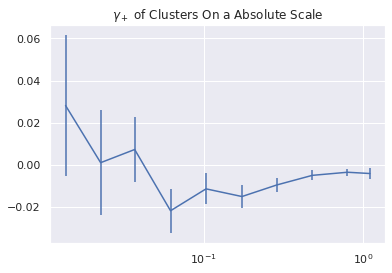

Aggregated xi:
[ -2.6231  -0.1838  -2.5667  16.3379  19.8891  61.457   90.9175 100.7369
 157.2053  91.0053]
------------------------------------------------------------------------------
Aggregated meanlogr:
[  -399.8841   -625.7634  -1151.9144  -2097.8681  -3996.4451  -7203.4299
 -11999.6526 -15086.9301 -10354.8399   2238.9057]
------------------------------------------------------------------------------
Aggregated npairs:
[   93.   165.   349.   754.  1761.  4116.  9633. 20584. 45927. 22606.]
------------------------------------------------------------------------------
Mean xi:
[-0.0282 -0.0011 -0.0074  0.0217  0.0113  0.0149  0.0094  0.0049  0.0034
  0.004 ]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2998 -3.7925 -3.3006 -2.7823 -2.2694 -1.7501 -1.2457 -0.7329 -0.2255
  0.099 ]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

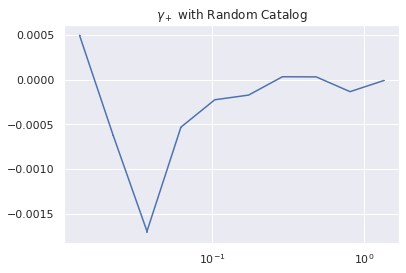

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

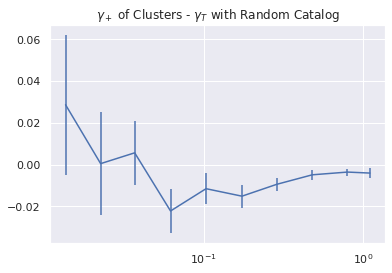

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

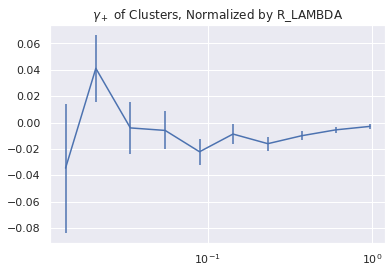

Aggregated xi:
[  1.2458  -4.4835   0.8518   2.5123  18.1765  16.5541  67.5157  92.4459
 105.4568 116.5652]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -154.55    -421.6904  -707.5091 -1216.8994 -1981.1205 -3689.5992
 -6143.9857 -9105.1604 -9633.5802 -1171.9088]
------------------------------------------------------------------------------
Aggregated npairs:
[3.6000e+01 1.0900e+02 2.0900e+02 4.2000e+02 8.2000e+02 1.8950e+03
 4.2100e+03 9.2400e+03 1.9103e+04 3.9975e+04]
------------------------------------------------------------------------------
Mean xi:
[ 0.0346 -0.0411  0.0041  0.006   0.0222  0.0087  0.016   0.01    0.0055
  0.0029]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.2931 -3.8687 -3.3852 -2.8974 -2.416  -1.947  -1.4594 -0.9854 -0.5043
 -0.0293]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)